In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds


def prepare_mnist_data(ds):
    return ds.map(to_float32).map(set_target).shuffle(10240).batch(256).prefetch(1280)


def to_float32(value, target):
    return tf.cast(value, tf.float32), target


def set_target(value, target):
    return value, value


def get_data_set():
    train_ds, test_ds = tfds.load('MNIST', split=['train', 'test'], as_supervised=True)
    train_dataset = train_ds.apply(prepare_mnist_data)
    test_dataset = test_ds.apply(prepare_mnist_data)
    return train_dataset, test_dataset

In [5]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
from tensorflow import math as tfm
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Conv2DTranspose, Flatten, Reshape, Rescaling
import matplotlib.pyplot as plt


class BetaVAE(tf.keras.Model):

    def __init__(self, latent_size, beta=1, learning_rate=0.001):
        super(BetaVAE, self).__init__()
        self.encoder = EncoderModel(latent_size)
        self.decoder = DecoderModel()
        self.beta = beta
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.compile(optimizer=optimizer)

    @tf.function
    def call(self, inputs):
        mu, sigma = self.encoder(inputs)
        distribution = tfd.Normal(mu, sigma)
        return self.decoder(distribution.sample()), mu, sigma

    @tf.function
    def train_step(self, train_data, reconstruction_loss_fun):
        reconstruction_losses = 0.0
        klds = 0.0
        losses = 0.0
        for data in train_data:
            inp, tar = data
            with tf.GradientTape() as tape:
                img, mu, sigma = self(inp)
                reconstruction_loss = reconstruction_loss_fun(tar, img)
                # KL Divergence of a diagonal multivariate normal and a standard normal distribution
                kld = self.beta * 0.5 * tfm.reduce_sum(
                    (tfm.pow(sigma, 2) + tfm.pow(mu, 2) - 1 - tfm.log(tfm.pow(sigma, 2))))
                loss = 0.5 * (reconstruction_loss + kld)
            gradients = tape.gradient(loss, self.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            reconstruction_losses += reconstruction_loss
            klds += kld
            losses += loss
        return losses, reconstruction_losses, klds

    def train(self, train_dataset, test_dataset, epochs=100):
        self.show_test_img(test_dataset)
        tf.keras.backend.clear_session()
        loss_fun = tf.keras.losses.MeanSquaredError()
        for epoch in range(epochs):
            losses, reconstruction_losses, klds = self.train_step(train_dataset, loss_fun)
            batches = float(train_dataset.__len__())
            print(
                f"epoch {epoch}, loss={losses / batches}, reconstruction_loss={reconstruction_losses / batches}, KLD={klds / batches}")
            self.show_test_img(test_dataset)

    def show_test_img(self, data_set):
        images = None
        for d in data_set.take(1):
            images, _ = d
        plt.imshow(images[0].numpy().astype("uint8")[:, :, 0], cmap='gray')
        plt.show()
        x, _, _ = self(images)
        plt.imshow(x[0].numpy().astype("uint8")[:, :, 0], cmap='gray')
        plt.show()


class EncoderModel(tf.keras.Model):

    def __init__(self, latent_size):
        super(EncoderModel, self).__init__()
        self.scaling = Rescaling(1. / 255)
        self.conv_layer1 = Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.pooling1 = MaxPool2D(pool_size=2, strides=2)
        self.conv_layer2 = Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.pooling2 = MaxPool2D(pool_size=2, strides=2)
        self.conv_layer3 = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.flatten = Flatten()
        self.mu = Dense(latent_size, activation=None)
        self.sigma = Dense(latent_size, activation=tf.nn.softplus)

    @tf.function
    def call(self, inputs):
        x = self.scaling(inputs)
        x = self.conv_layer1(x)
        x = self.pooling1(x)
        x = self.conv_layer2(x)
        x = self.pooling2(x)
        x = self.conv_layer3(x)
        x = self.flatten(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        return mu, sigma


class DecoderModel(tf.keras.Model):

    def __init__(self):
        super(DecoderModel, self).__init__()
        self.dense = Dense(3136, activation=tf.nn.relu)  # 7 * 7 * 64 = 3.136
        self.reshape = Reshape((7, 7, 64))
        self.conv_t1 = Conv2DTranspose(filters=64, kernel_size=3, padding='same', strides=2, activation=tf.nn.relu)
        self.conv_t2 = Conv2DTranspose(filters=32, kernel_size=3, padding='same', strides=2, activation=tf.nn.relu)
        self.conv = Conv2D(filters=1, kernel_size=3, padding='same', activation=tf.nn.sigmoid)
        self.out = Rescaling(255)

    @tf.function
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv_t1(x)
        x = self.conv_t2(x)
        x = self.conv(x)
        x = self.out(x)
        return x

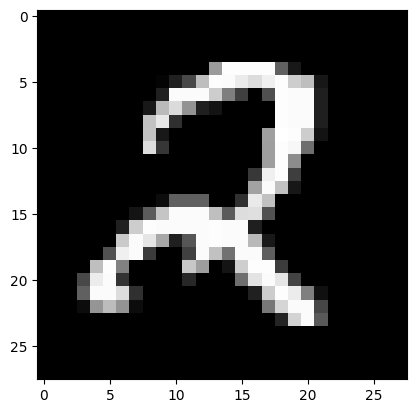

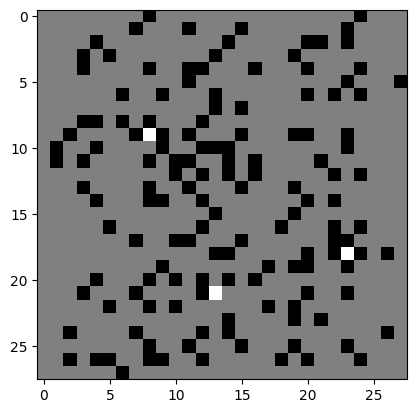

epoch 0, loss=2595.5126953125, reconstruction_loss=5097.73046875, KLD=93.293212890625


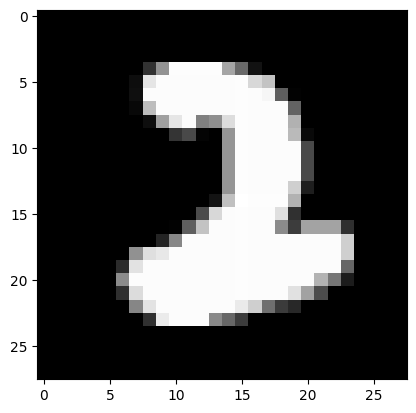

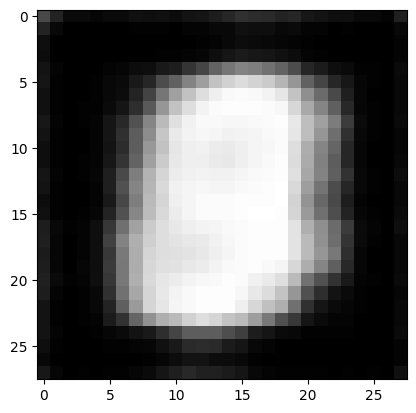

epoch 1, loss=2084.5, reconstruction_loss=3804.03662109375, KLD=364.9642333984375


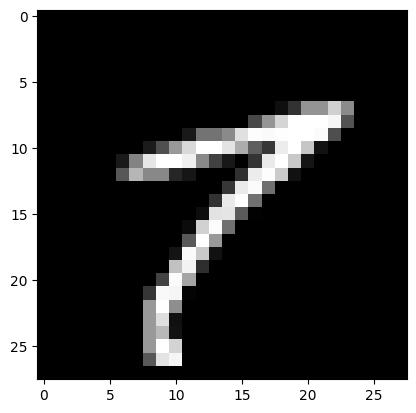

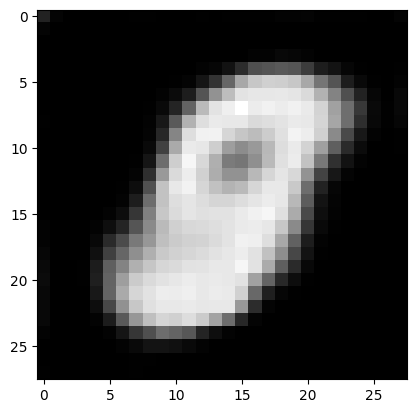

epoch 2, loss=1941.445556640625, reconstruction_loss=3174.478271484375, KLD=708.4134521484375


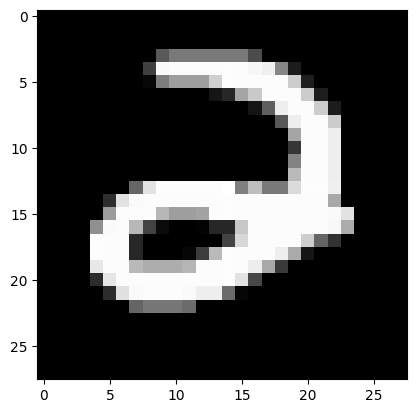

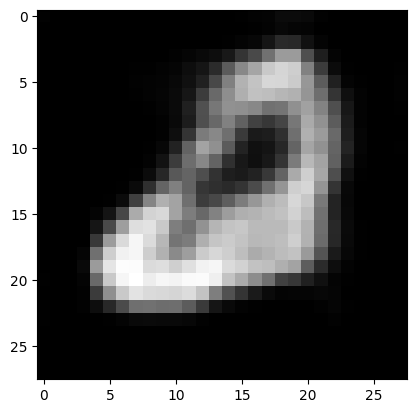

epoch 3, loss=1891.9556884765625, reconstruction_loss=2980.1669921875, KLD=803.7451171875


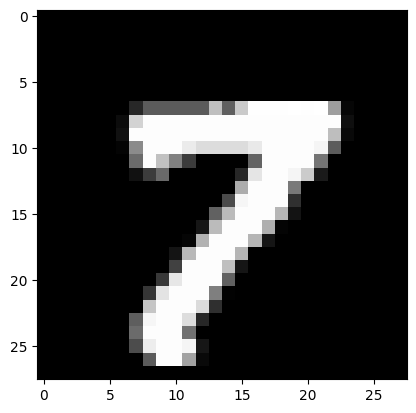

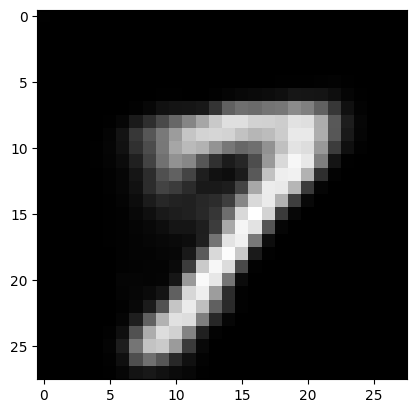

epoch 4, loss=1873.6541748046875, reconstruction_loss=2905.4453125, KLD=841.8617553710938


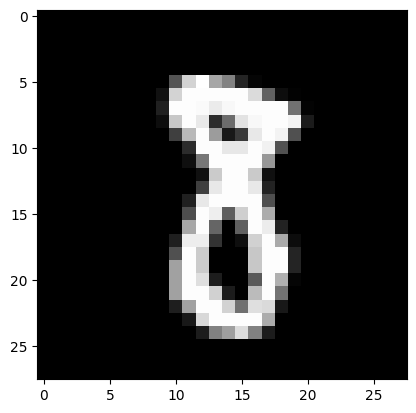

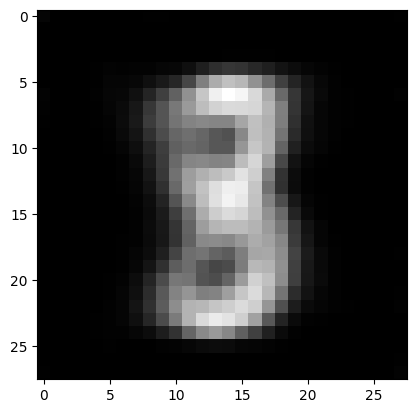

epoch 5, loss=1861.7044677734375, reconstruction_loss=2855.513671875, KLD=867.8936157226562


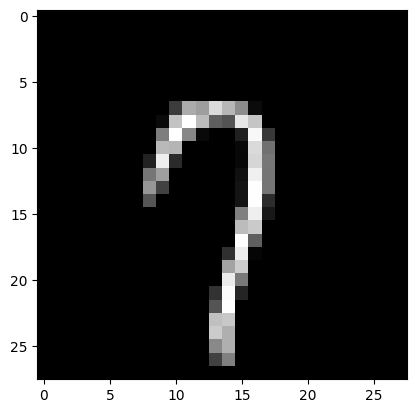

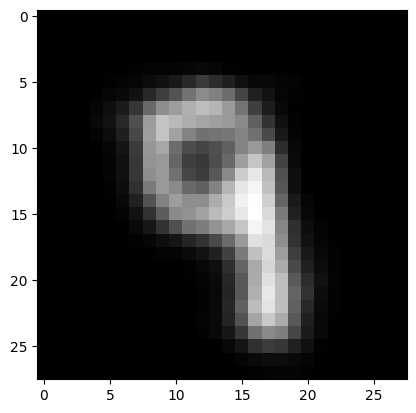

epoch 6, loss=1853.247314453125, reconstruction_loss=2821.642333984375, KLD=884.851806640625


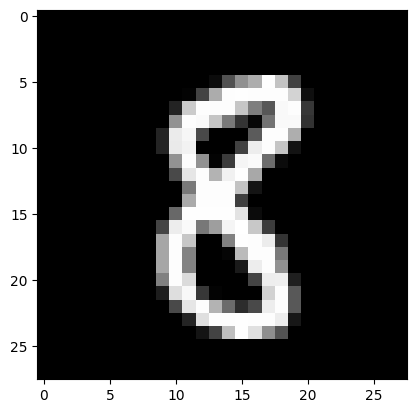

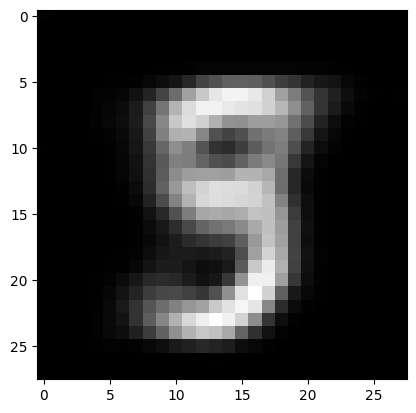

epoch 7, loss=1845.58349609375, reconstruction_loss=2789.173095703125, KLD=901.993896484375


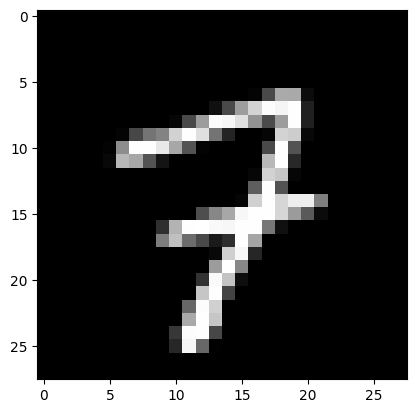

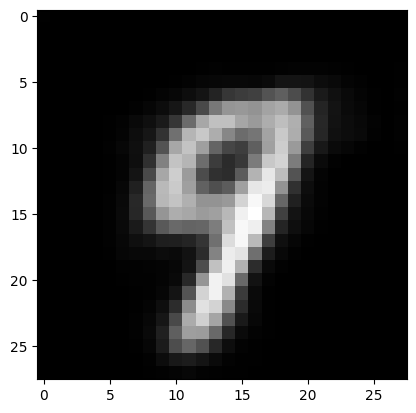

epoch 8, loss=1839.27587890625, reconstruction_loss=2769.1904296875, KLD=909.3609619140625


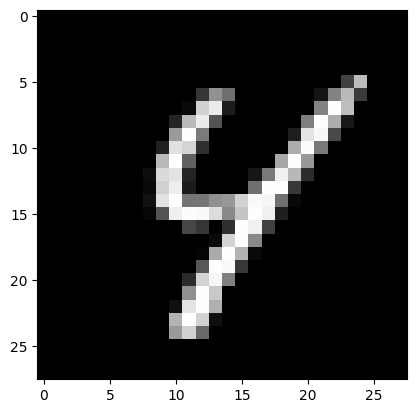

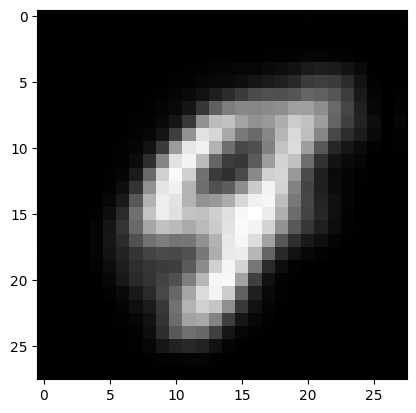

epoch 9, loss=1834.342041015625, reconstruction_loss=2747.47607421875, KLD=921.21044921875


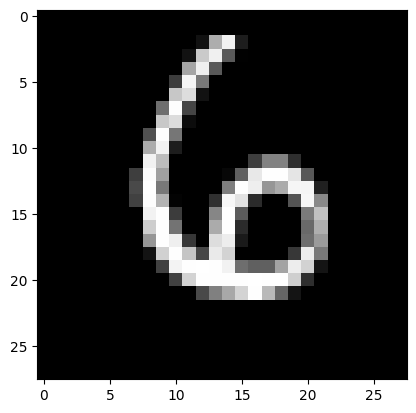

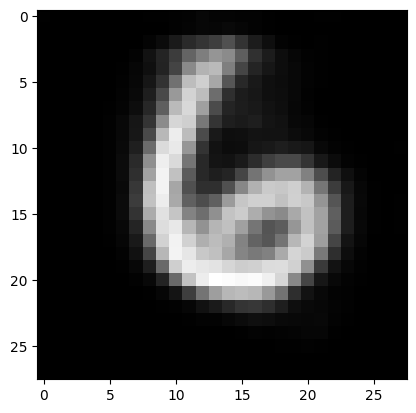

epoch 10, loss=1833.0860595703125, reconstruction_loss=2731.72705078125, KLD=934.445068359375


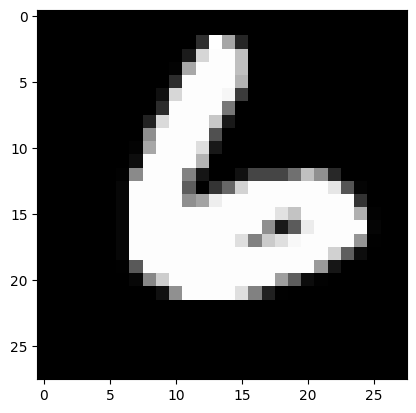

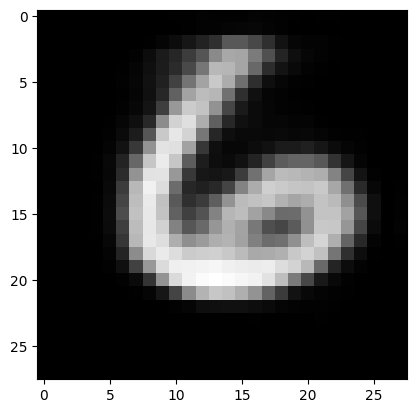

epoch 11, loss=1829.167236328125, reconstruction_loss=2716.3544921875, KLD=941.9820556640625


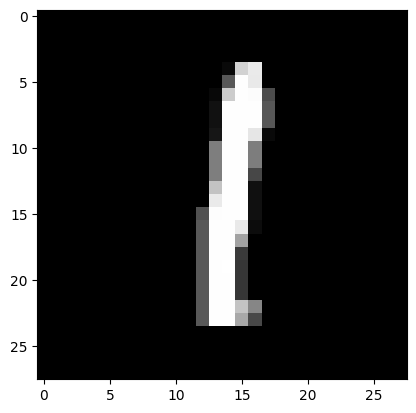

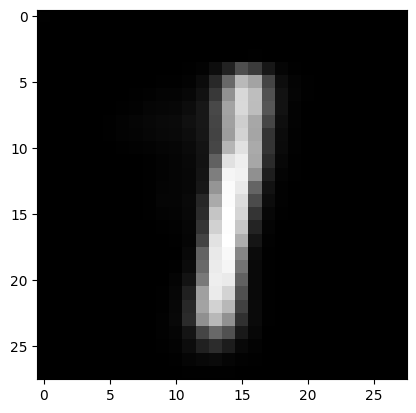

epoch 12, loss=1826.00830078125, reconstruction_loss=2700.518798828125, KLD=951.4971313476562


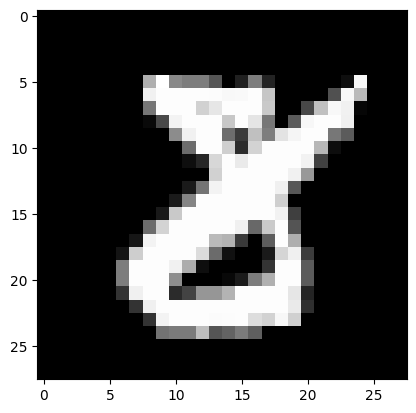

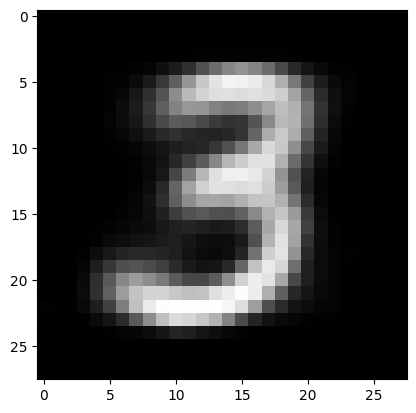

epoch 13, loss=1822.3922119140625, reconstruction_loss=2687.133056640625, KLD=957.6527709960938


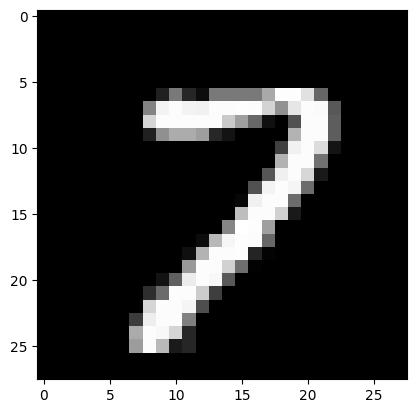

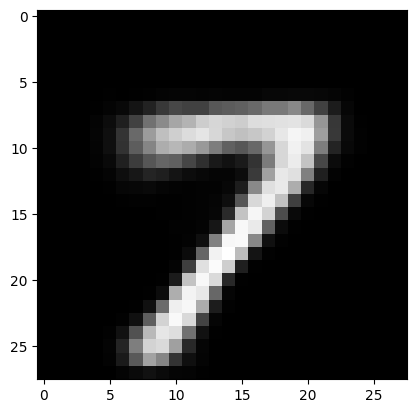

epoch 14, loss=1821.7513427734375, reconstruction_loss=2676.77294921875, KLD=966.728271484375


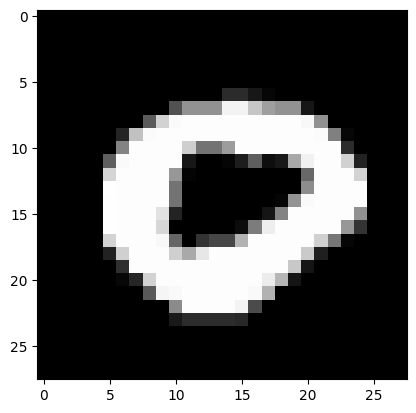

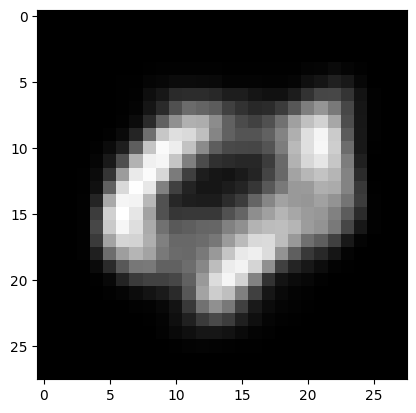

epoch 15, loss=1819.1094970703125, reconstruction_loss=2668.05908203125, KLD=970.1609497070312


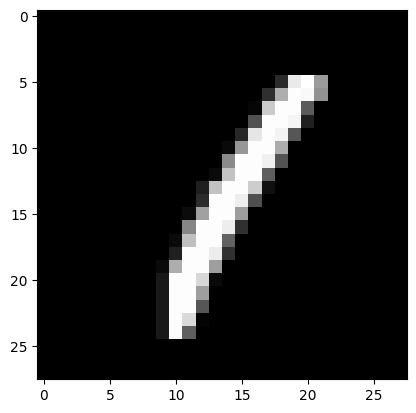

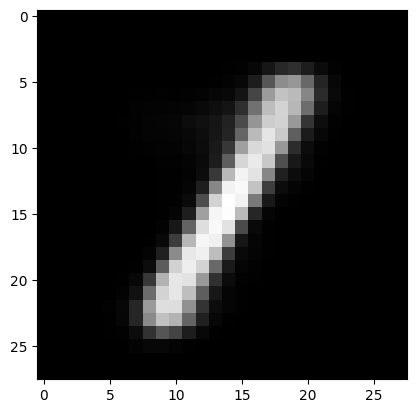

epoch 16, loss=1817.60009765625, reconstruction_loss=2657.7060546875, KLD=977.49267578125


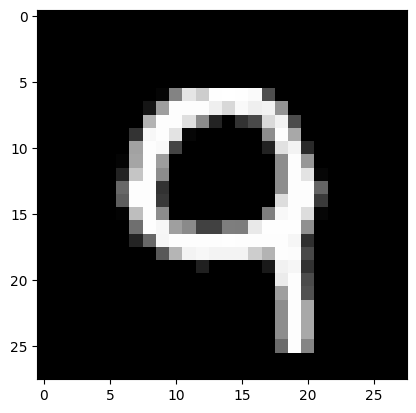

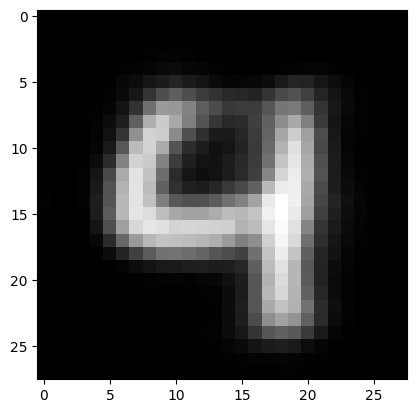

epoch 17, loss=1815.4671630859375, reconstruction_loss=2645.829345703125, KLD=985.1031494140625


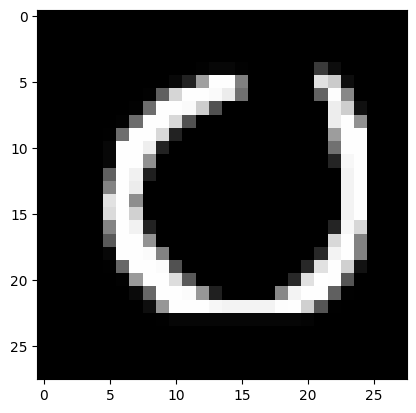

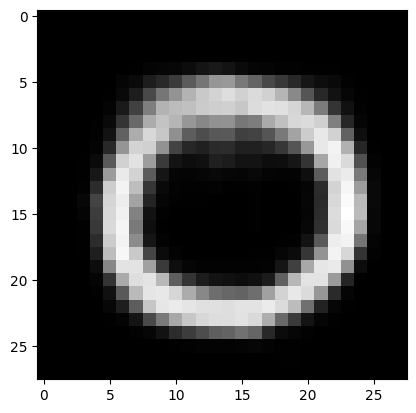

epoch 18, loss=1811.482666015625, reconstruction_loss=2637.393798828125, KLD=985.57275390625


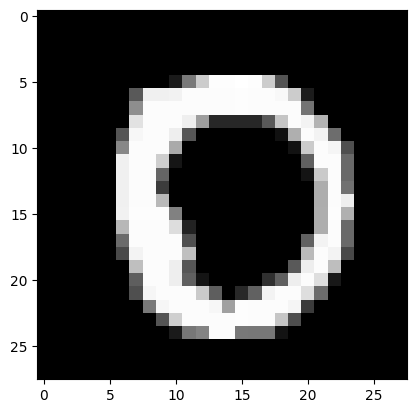

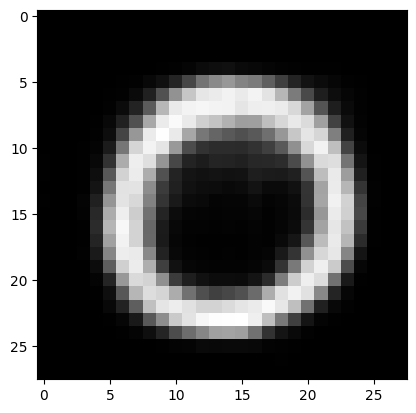

epoch 19, loss=1812.133056640625, reconstruction_loss=2626.97998046875, KLD=997.286865234375


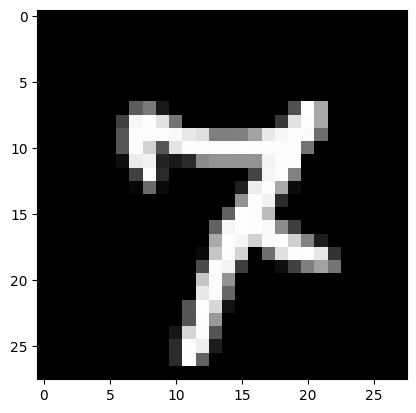

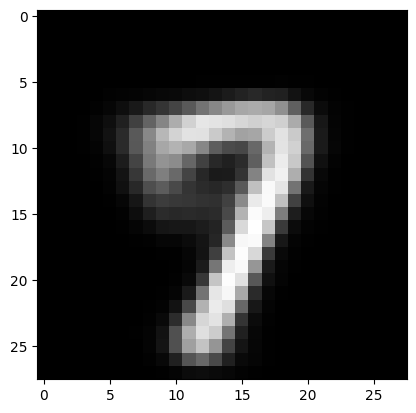

epoch 20, loss=1810.549560546875, reconstruction_loss=2622.203369140625, KLD=998.8963623046875


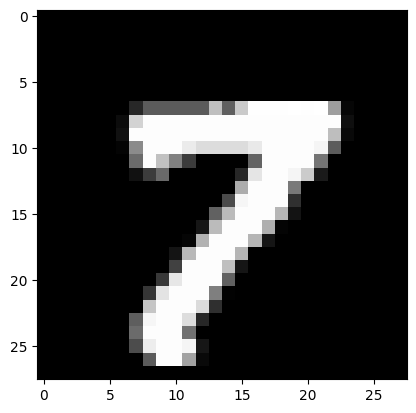

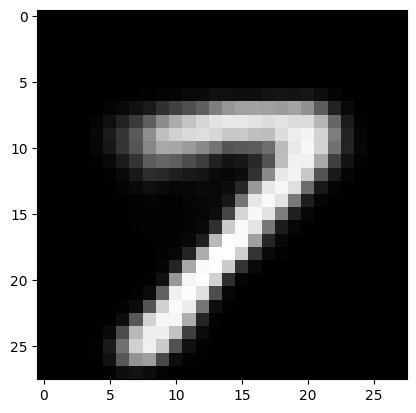

epoch 21, loss=1808.7279052734375, reconstruction_loss=2614.185546875, KLD=1003.270263671875


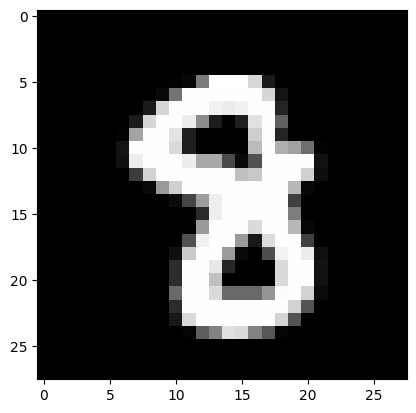

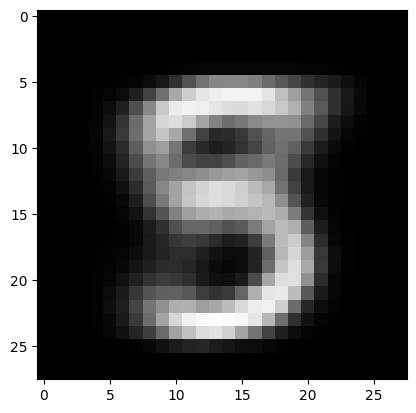

epoch 22, loss=1806.7010498046875, reconstruction_loss=2608.0673828125, KLD=1005.3359985351562


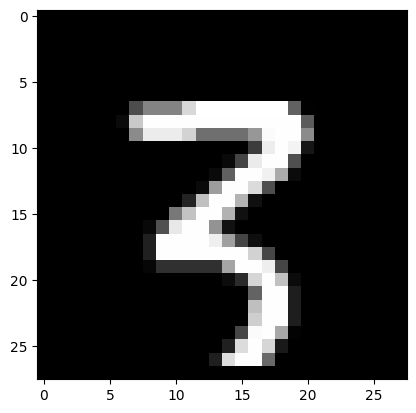

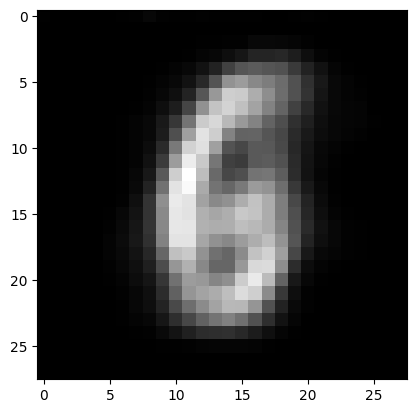

epoch 23, loss=1806.0633544921875, reconstruction_loss=2598.98095703125, KLD=1013.1453247070312


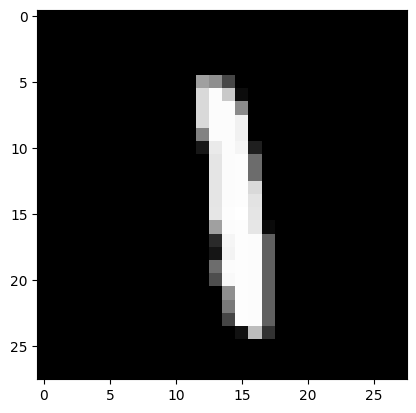

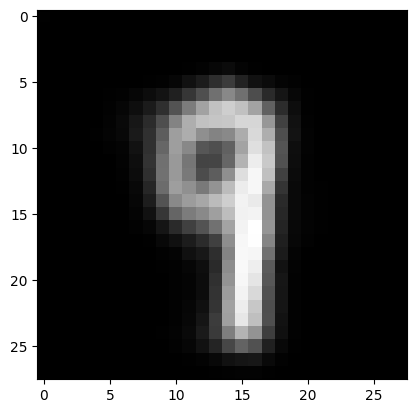

epoch 24, loss=1803.301513671875, reconstruction_loss=2588.7607421875, KLD=1017.8410034179688


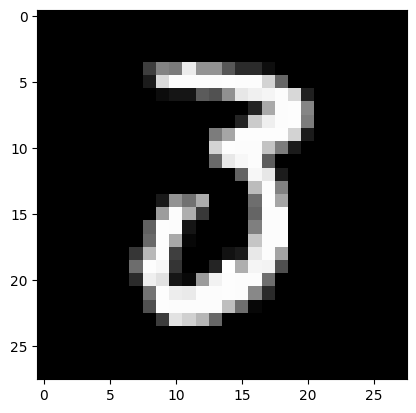

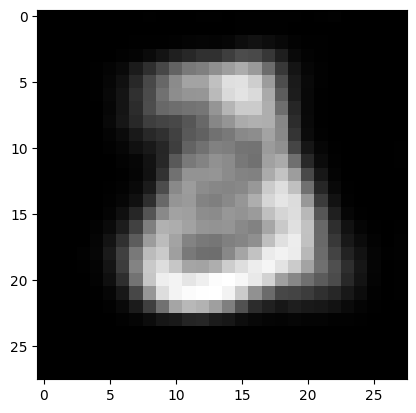

epoch 25, loss=1803.0994873046875, reconstruction_loss=2583.996826171875, KLD=1022.2025756835938


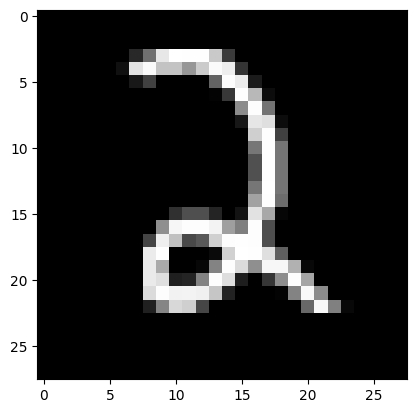

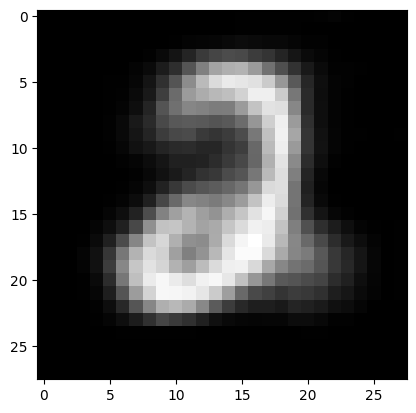

epoch 26, loss=1800.9683837890625, reconstruction_loss=2577.091796875, KLD=1024.8448486328125


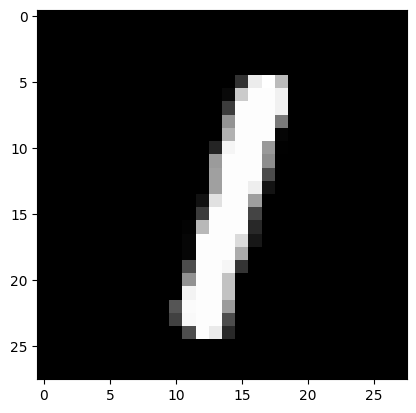

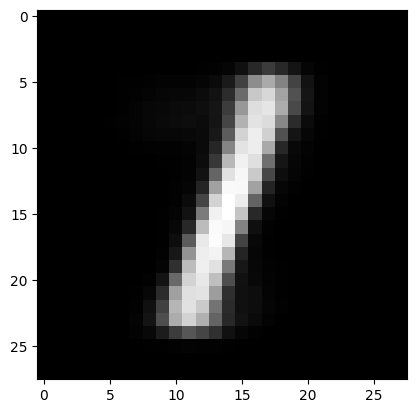

epoch 27, loss=1800.5718994140625, reconstruction_loss=2573.72216796875, KLD=1027.4227294921875


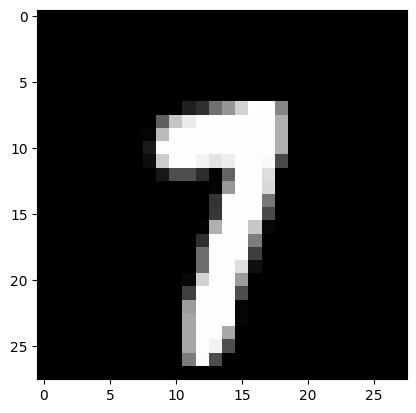

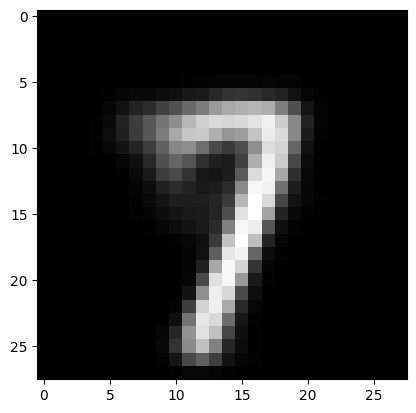

epoch 28, loss=1797.6378173828125, reconstruction_loss=2564.124267578125, KLD=1031.153076171875


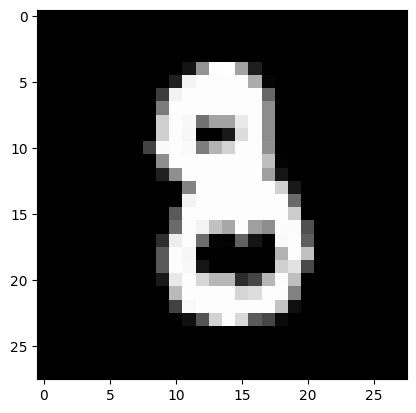

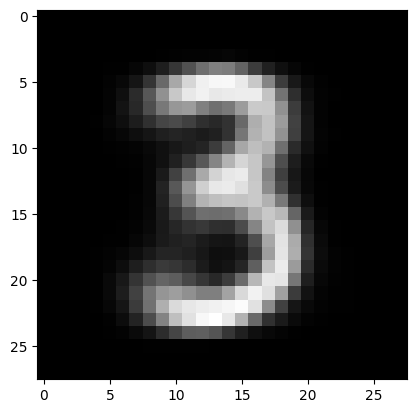

epoch 29, loss=1795.7003173828125, reconstruction_loss=2557.007568359375, KLD=1034.3924560546875


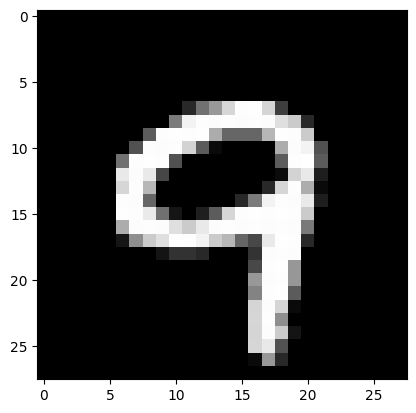

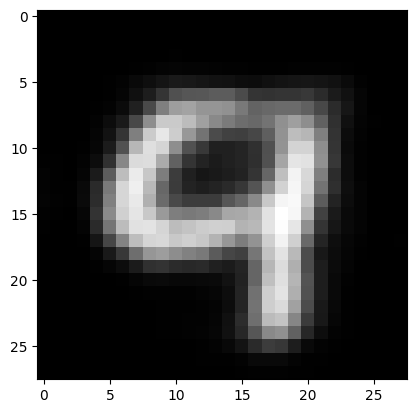

epoch 30, loss=1795.9656982421875, reconstruction_loss=2553.937744140625, KLD=1037.994873046875


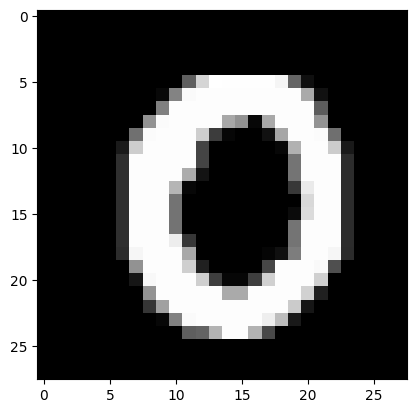

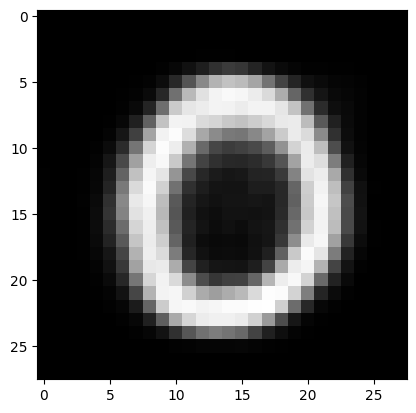

epoch 31, loss=1794.1558837890625, reconstruction_loss=2548.762939453125, KLD=1039.5489501953125


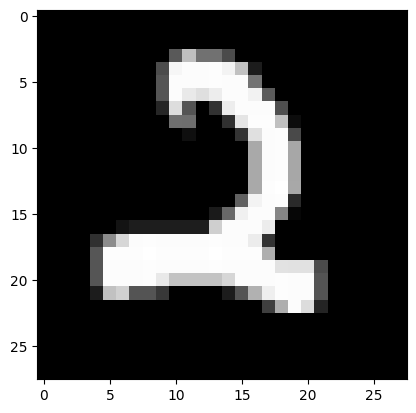

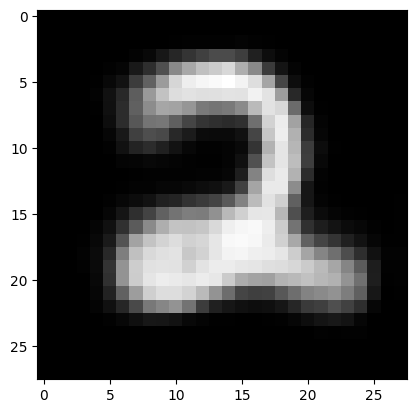

epoch 32, loss=1795.175537109375, reconstruction_loss=2547.6376953125, KLD=1042.7138671875


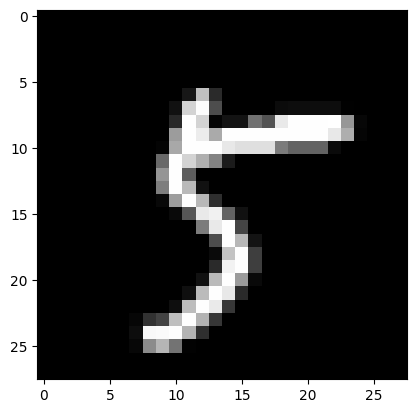

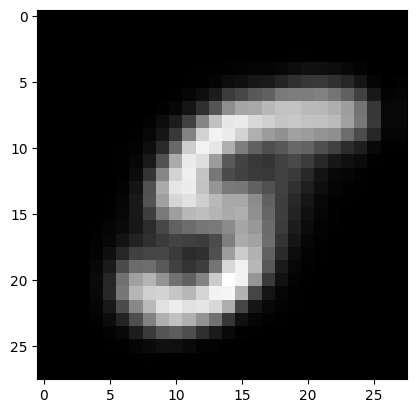

epoch 33, loss=1792.58544921875, reconstruction_loss=2539.297607421875, KLD=1045.874267578125


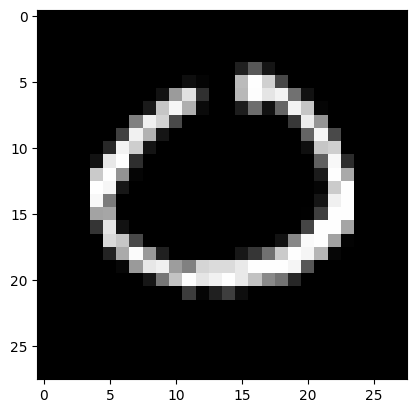

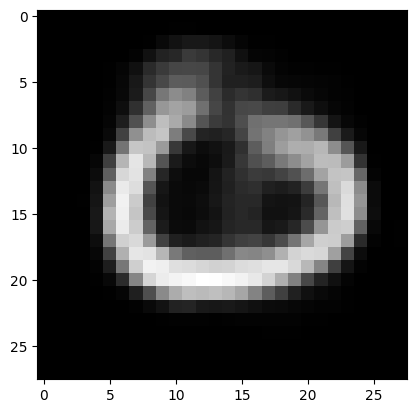

epoch 34, loss=1791.73681640625, reconstruction_loss=2534.9765625, KLD=1048.4971923828125


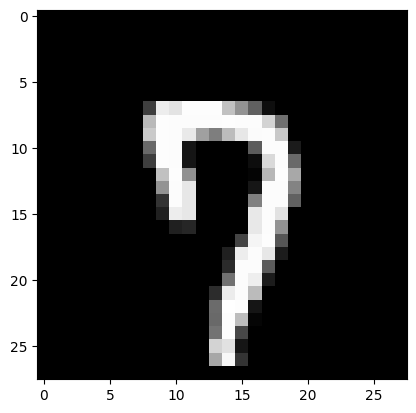

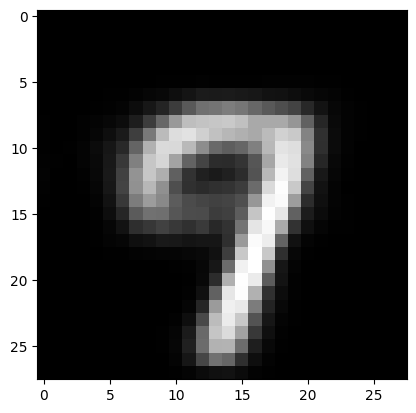

epoch 35, loss=1791.052490234375, reconstruction_loss=2530.815673828125, KLD=1051.2891845703125


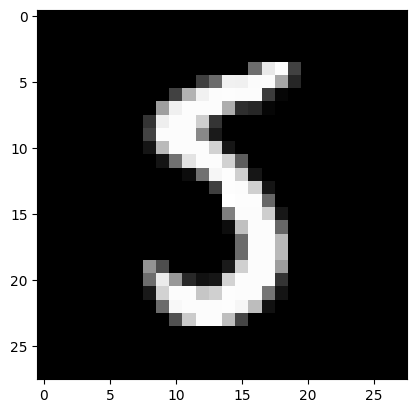

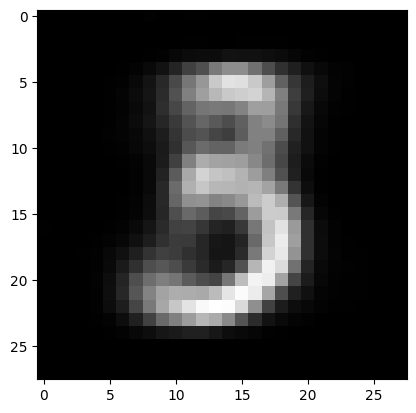

epoch 36, loss=1788.7958984375, reconstruction_loss=2526.166015625, KLD=1051.42626953125


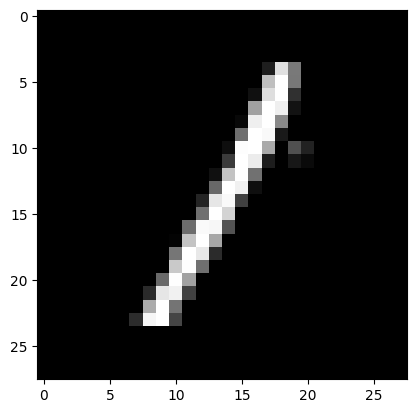

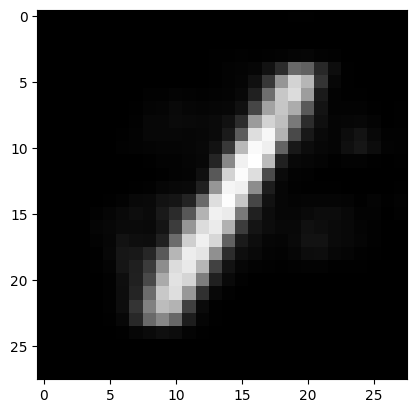

epoch 37, loss=1790.433349609375, reconstruction_loss=2524.509033203125, KLD=1056.3594970703125


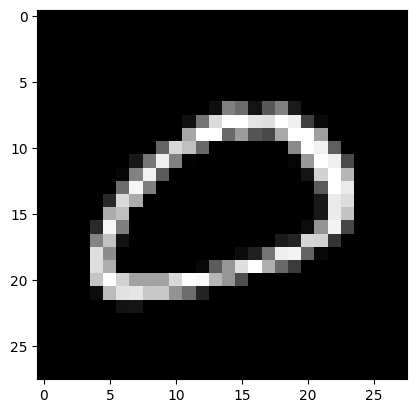

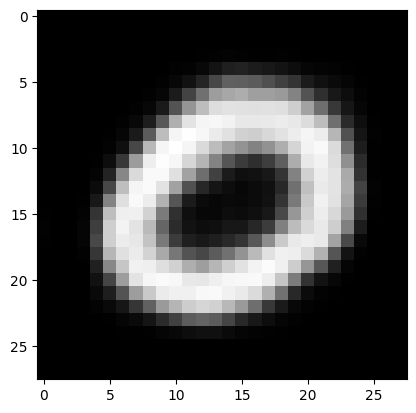

epoch 38, loss=1788.14794921875, reconstruction_loss=2521.967041015625, KLD=1054.3287353515625


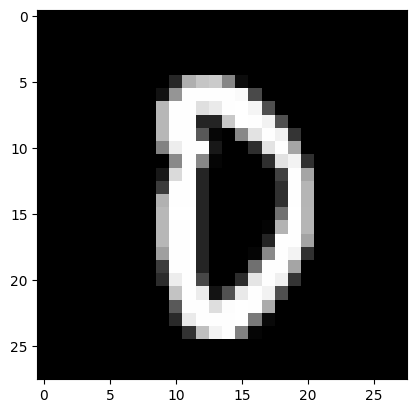

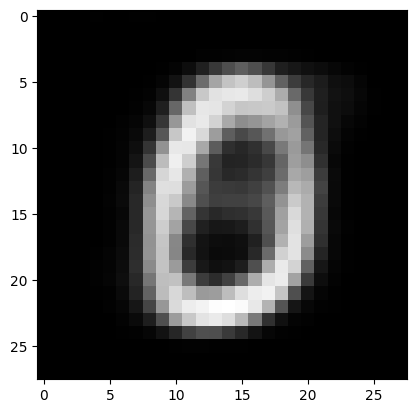

epoch 39, loss=1786.140869140625, reconstruction_loss=2513.73779296875, KLD=1058.5430908203125


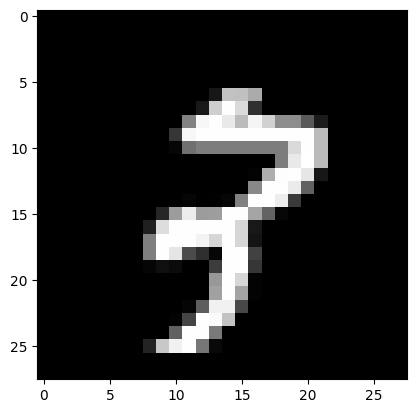

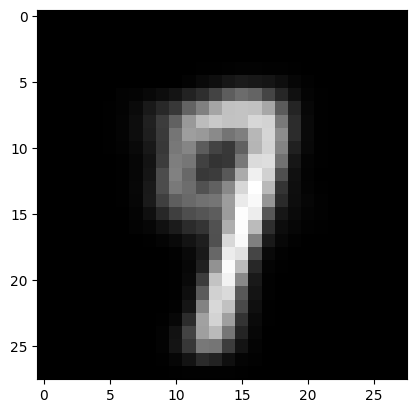

epoch 40, loss=1789.740478515625, reconstruction_loss=2515.983154296875, KLD=1063.4967041015625


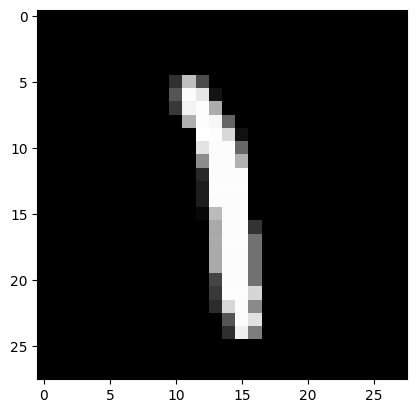

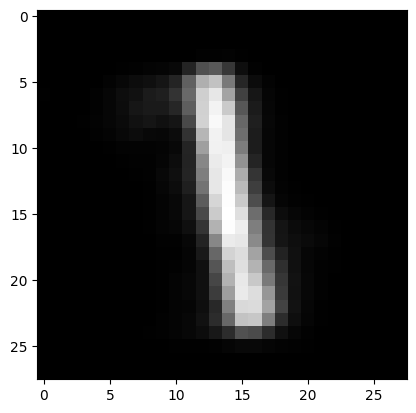

epoch 41, loss=1786.47509765625, reconstruction_loss=2506.592041015625, KLD=1066.3570556640625


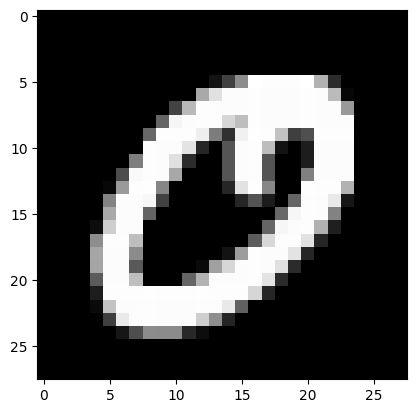

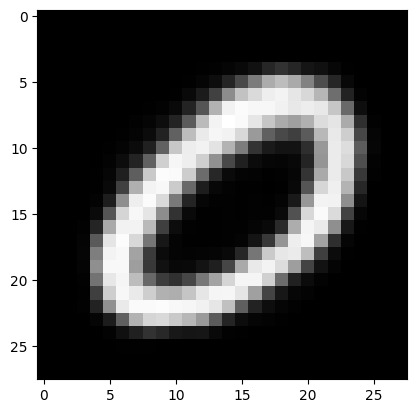

epoch 42, loss=1785.9136962890625, reconstruction_loss=2504.134765625, KLD=1067.69091796875


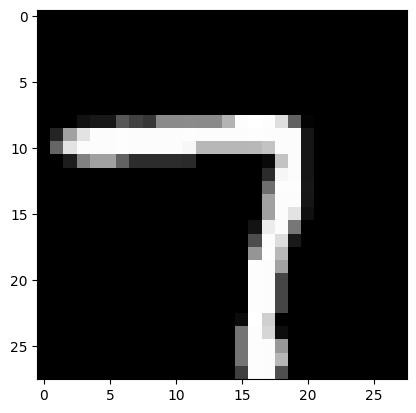

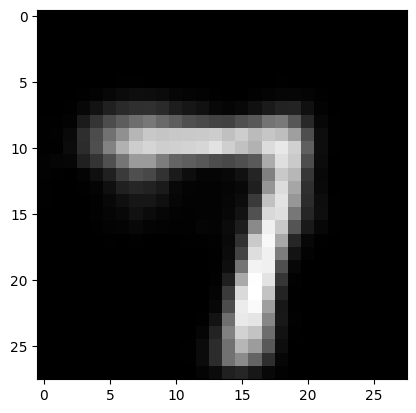

epoch 43, loss=1785.73876953125, reconstruction_loss=2502.67919921875, KLD=1068.7960205078125


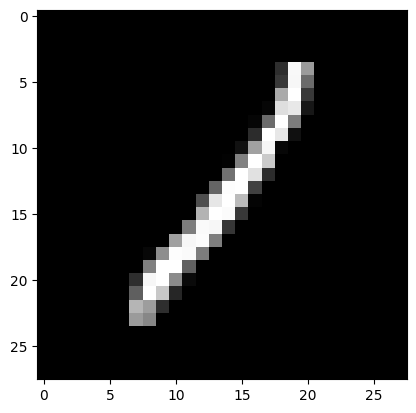

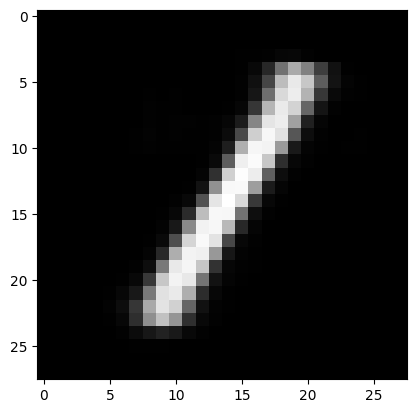

epoch 44, loss=1785.3692626953125, reconstruction_loss=2502.5078125, KLD=1068.23095703125


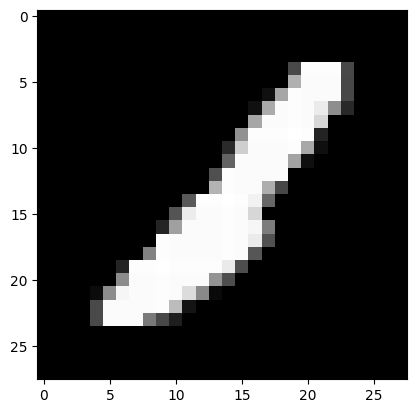

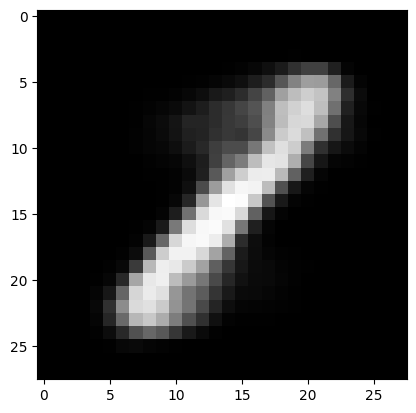

epoch 45, loss=1785.9581298828125, reconstruction_loss=2498.1728515625, KLD=1073.744140625


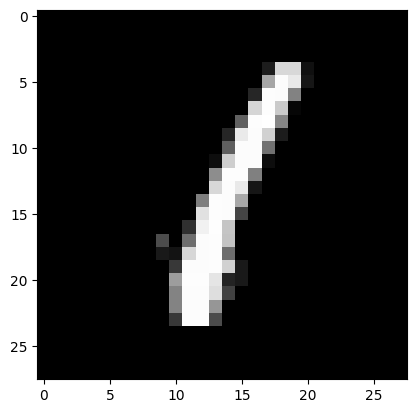

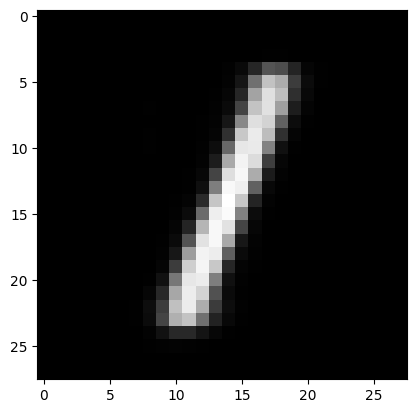

epoch 46, loss=1784.2806396484375, reconstruction_loss=2494.348876953125, KLD=1074.2113037109375


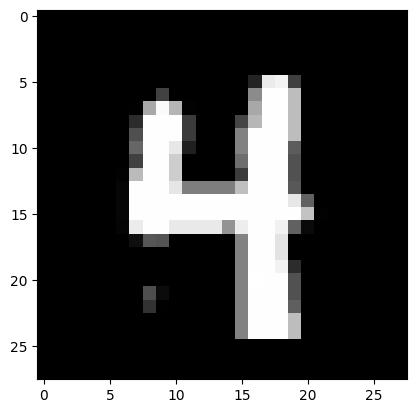

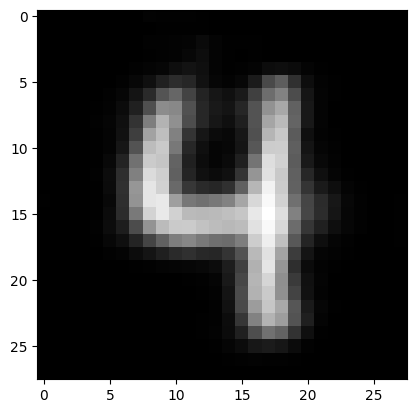

epoch 47, loss=1783.513916015625, reconstruction_loss=2492.42041015625, KLD=1074.6064453125


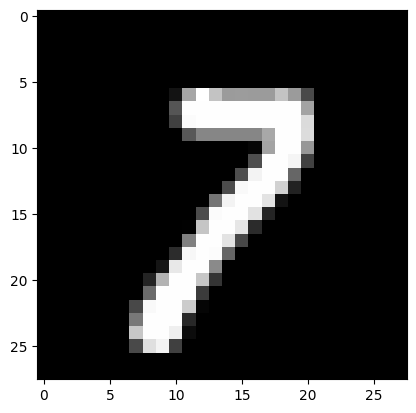

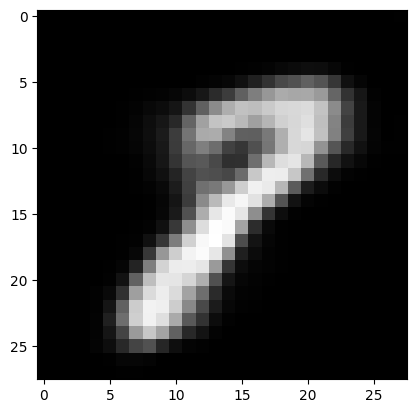

epoch 48, loss=1781.481689453125, reconstruction_loss=2487.099365234375, KLD=1075.8634033203125


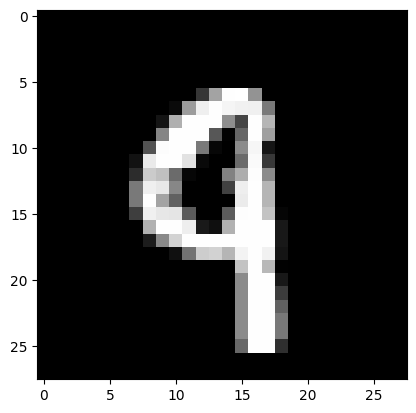

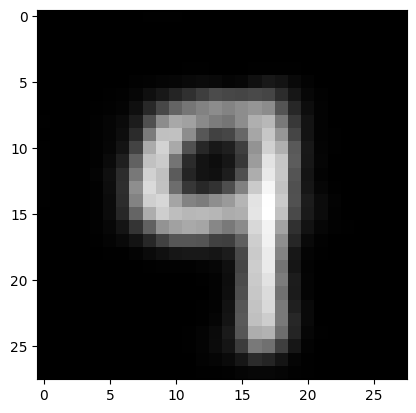

epoch 49, loss=1782.8702392578125, reconstruction_loss=2488.674560546875, KLD=1077.06591796875


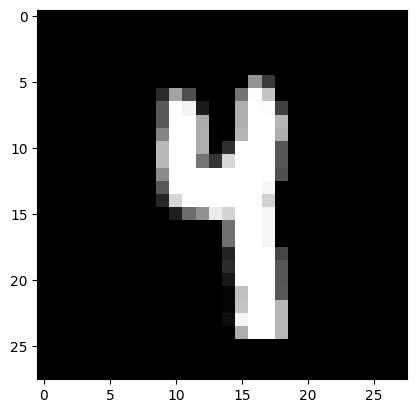

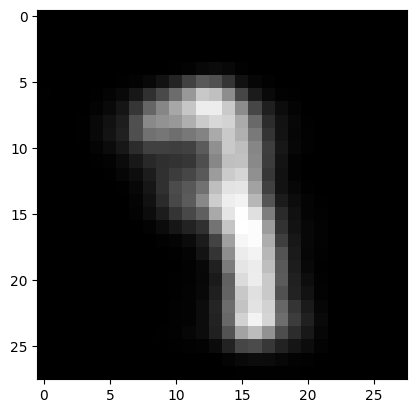

epoch 50, loss=1783.69384765625, reconstruction_loss=2485.073974609375, KLD=1082.313720703125


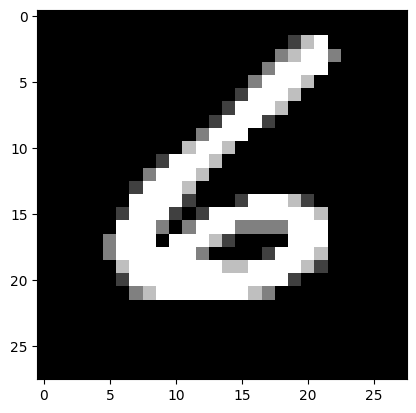

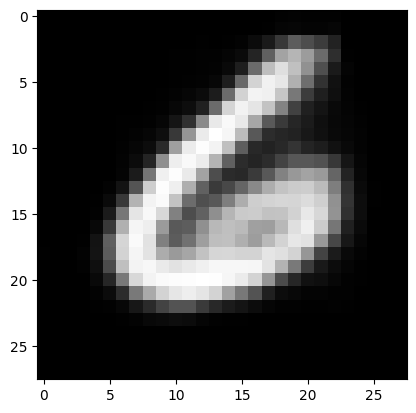

epoch 51, loss=1778.18408203125, reconstruction_loss=2479.7958984375, KLD=1076.5703125


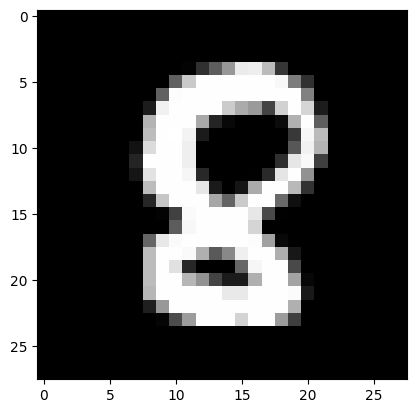

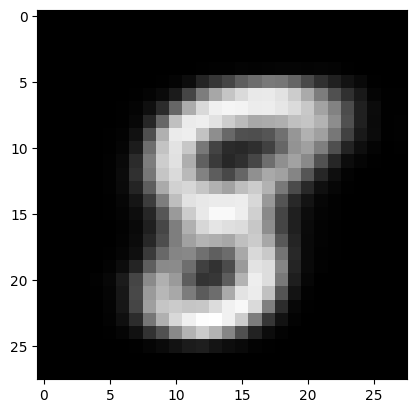

epoch 52, loss=1780.5703125, reconstruction_loss=2481.176513671875, KLD=1079.963623046875


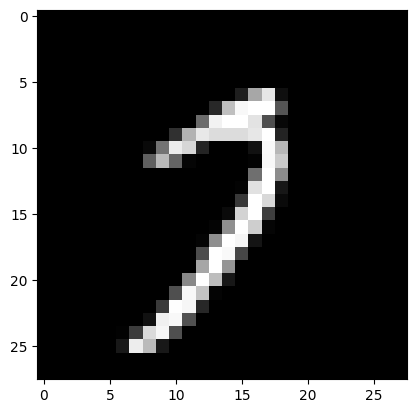

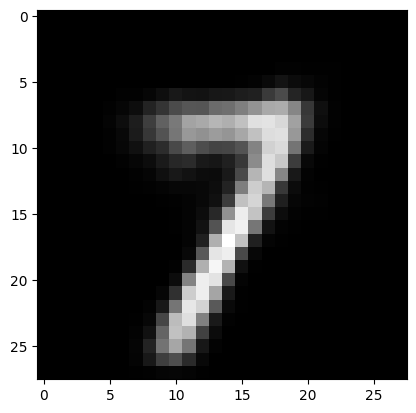

epoch 53, loss=1781.2144775390625, reconstruction_loss=2478.9013671875, KLD=1083.52587890625


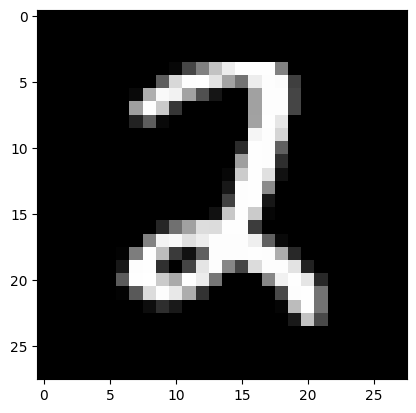

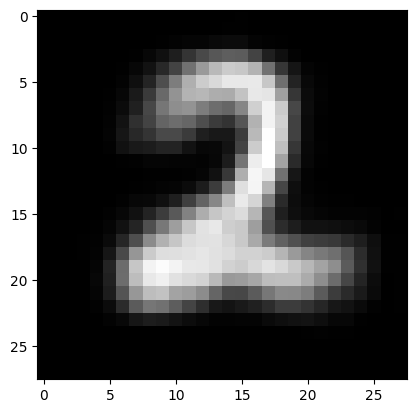

epoch 54, loss=1781.3006591796875, reconstruction_loss=2475.807861328125, KLD=1086.796630859375


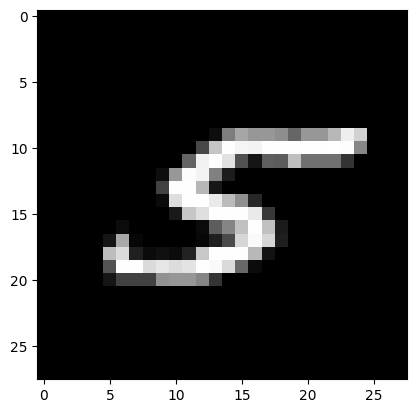

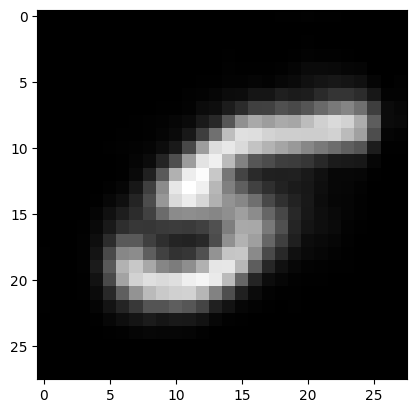

epoch 55, loss=1781.537841796875, reconstruction_loss=2474.2451171875, KLD=1088.830322265625


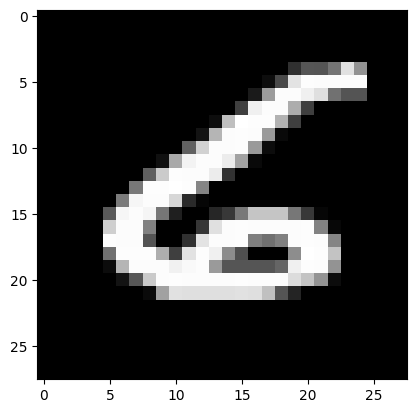

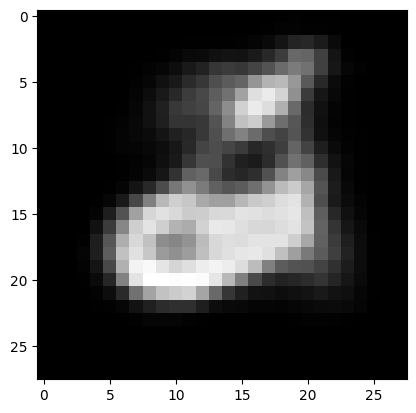

epoch 56, loss=1780.673095703125, reconstruction_loss=2471.623291015625, KLD=1089.7218017578125


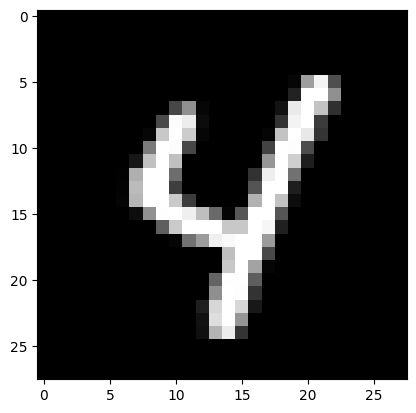

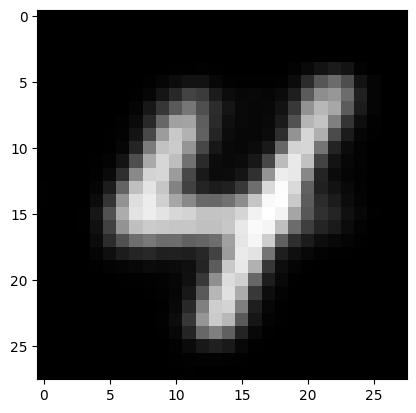

epoch 57, loss=1777.26953125, reconstruction_loss=2470.46435546875, KLD=1084.0758056640625


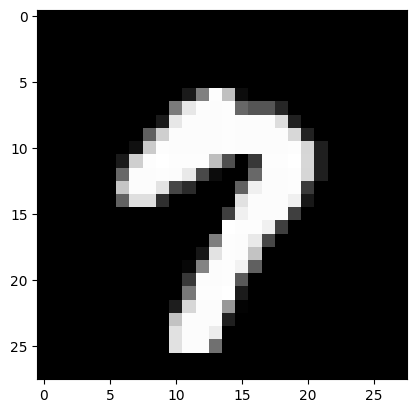

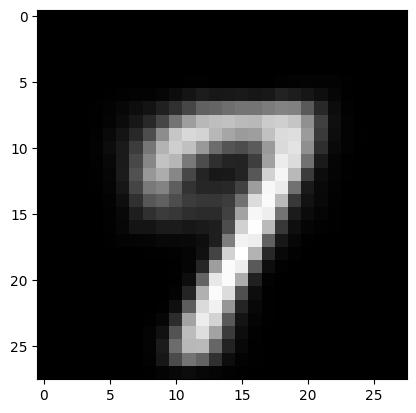

epoch 58, loss=1777.383544921875, reconstruction_loss=2466.9169921875, KLD=1087.8485107421875


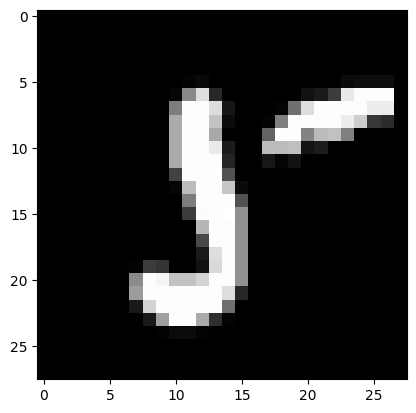

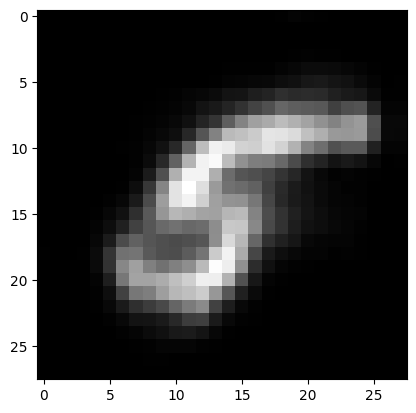

epoch 59, loss=1781.00830078125, reconstruction_loss=2467.30078125, KLD=1094.7152099609375


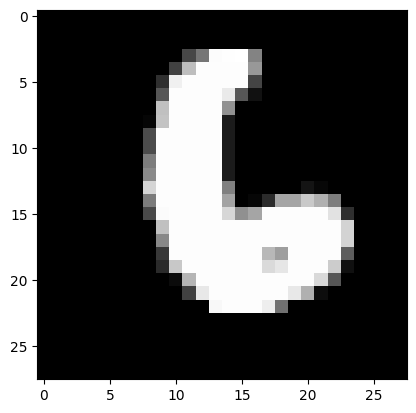

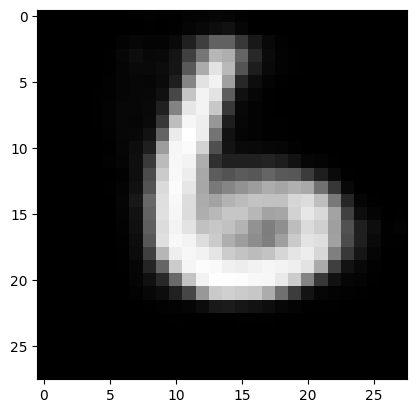

epoch 60, loss=1777.939453125, reconstruction_loss=2463.89990234375, KLD=1091.97900390625


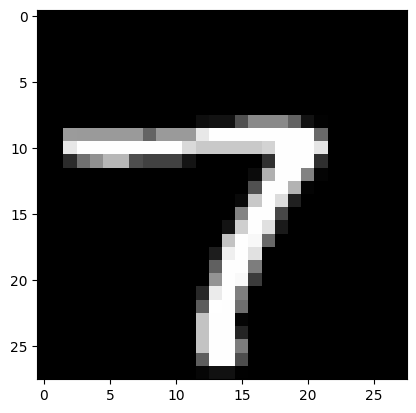

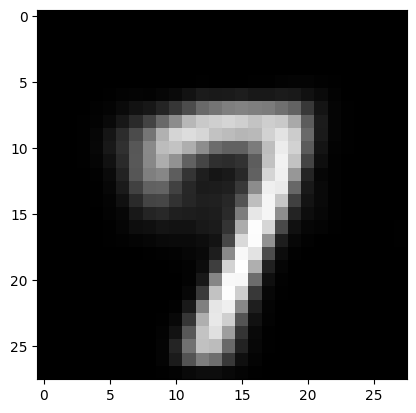

epoch 61, loss=1779.2913818359375, reconstruction_loss=2464.122314453125, KLD=1094.46142578125


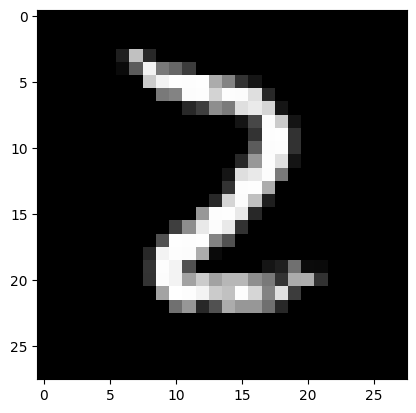

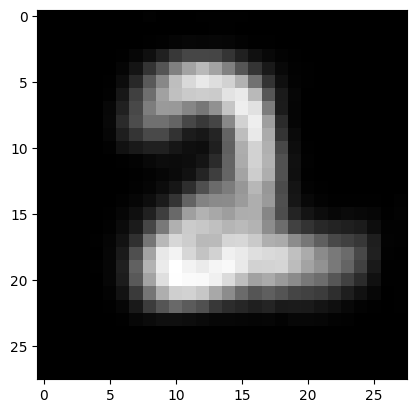

epoch 62, loss=1777.92919921875, reconstruction_loss=2464.866943359375, KLD=1090.9910888671875


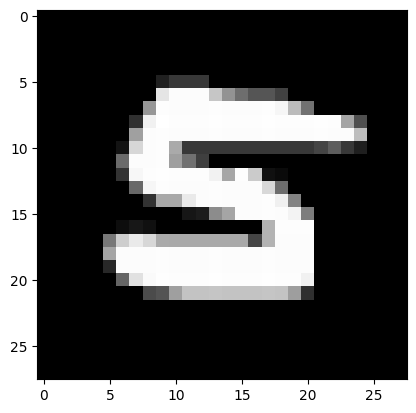

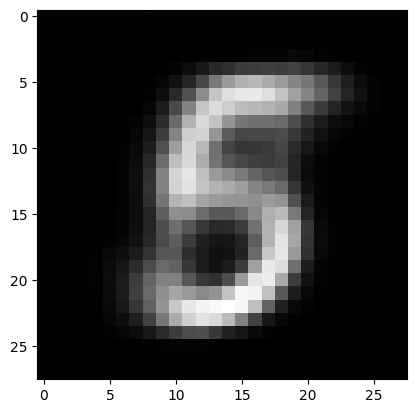

epoch 63, loss=1776.635009765625, reconstruction_loss=2460.12158203125, KLD=1093.1473388671875


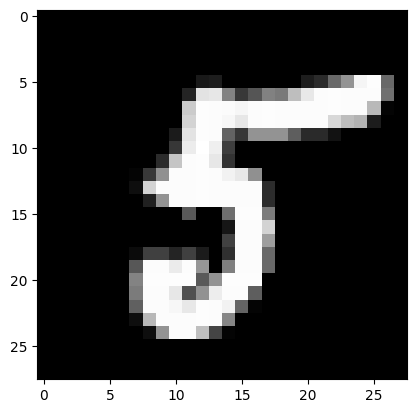

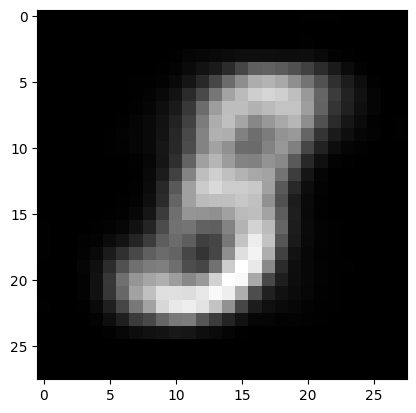

epoch 64, loss=1774.9996337890625, reconstruction_loss=2458.52001953125, KLD=1091.4794921875


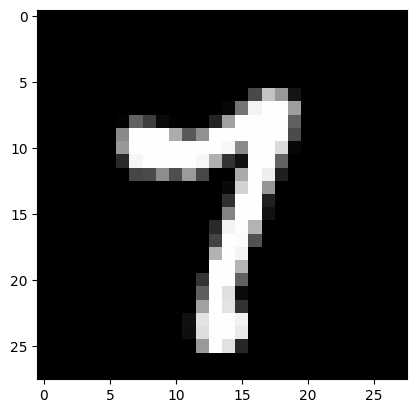

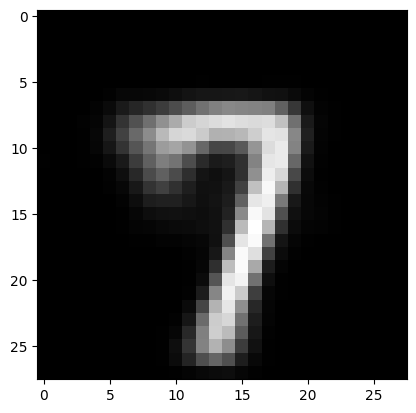

epoch 65, loss=1775.2857666015625, reconstruction_loss=2455.587646484375, KLD=1094.984619140625


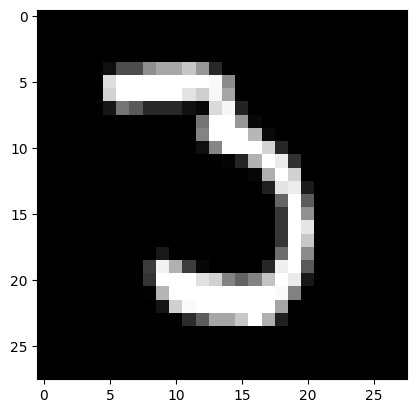

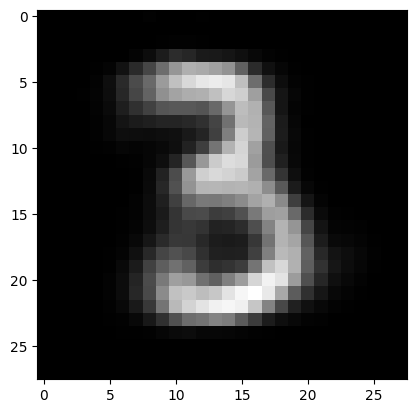

epoch 66, loss=1773.9615478515625, reconstruction_loss=2456.139892578125, KLD=1091.782470703125


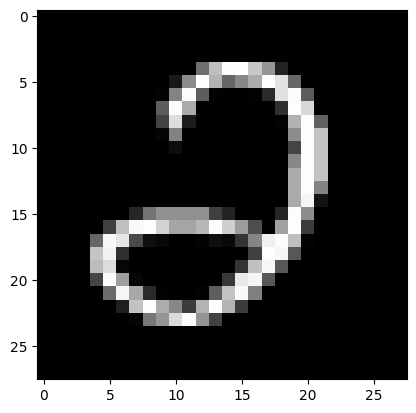

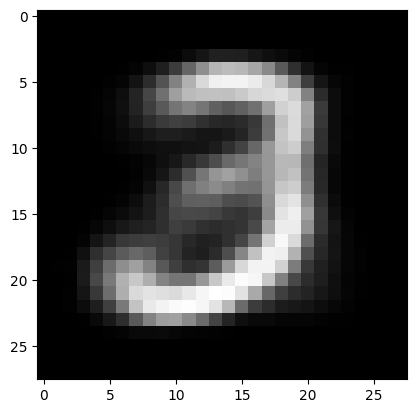

epoch 67, loss=1775.6767578125, reconstruction_loss=2452.8486328125, KLD=1098.50390625


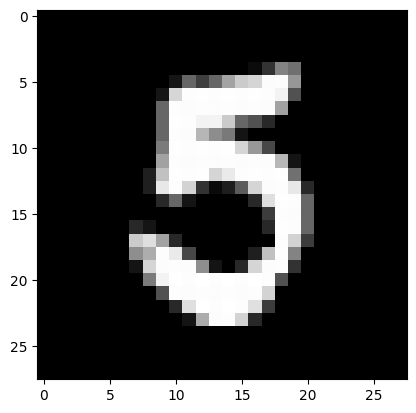

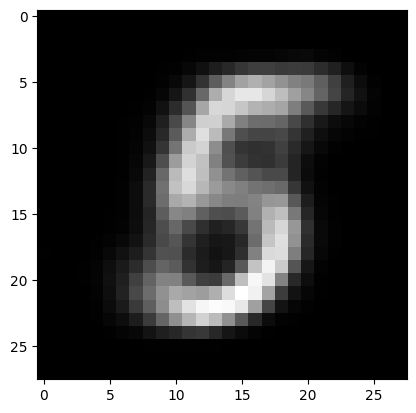

epoch 68, loss=1774.3900146484375, reconstruction_loss=2451.6748046875, KLD=1097.104736328125


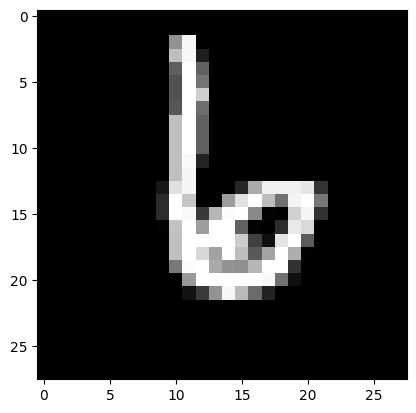

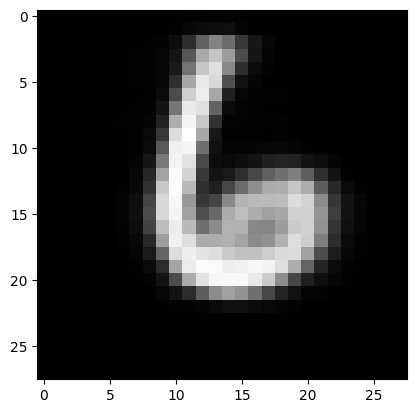

epoch 69, loss=1774.9241943359375, reconstruction_loss=2449.37890625, KLD=1100.4698486328125


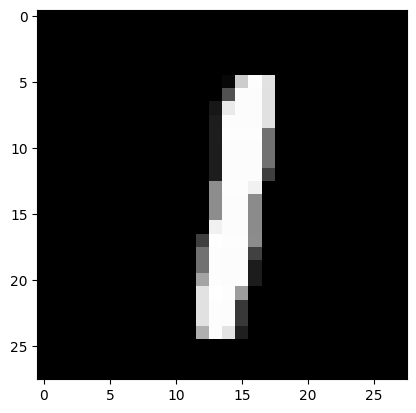

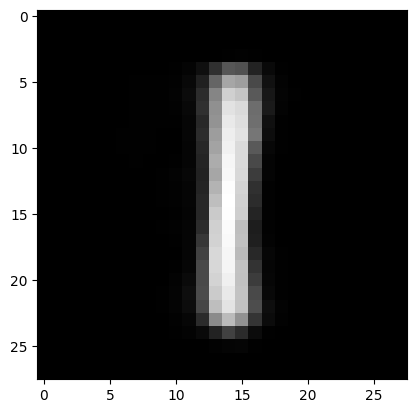

epoch 70, loss=1775.6998291015625, reconstruction_loss=2450.718994140625, KLD=1100.6827392578125


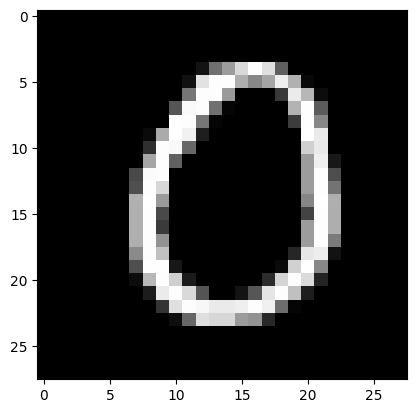

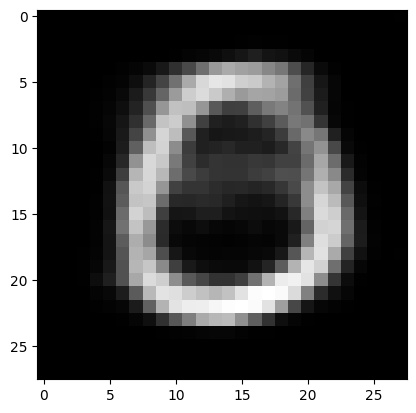

epoch 71, loss=1774.28564453125, reconstruction_loss=2445.55859375, KLD=1103.01171875


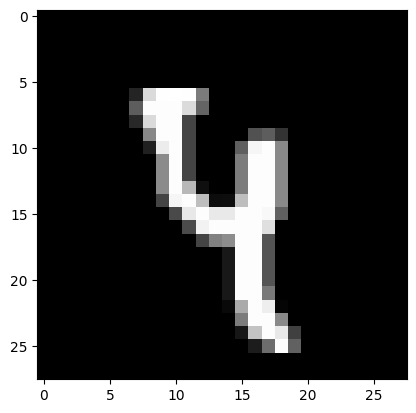

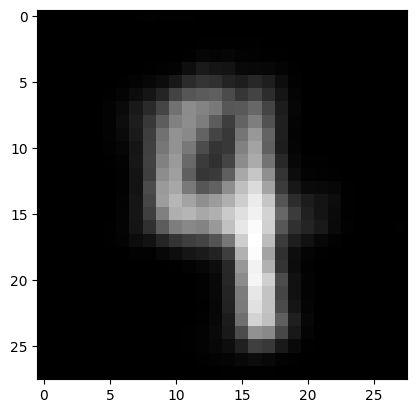

epoch 72, loss=1773.23388671875, reconstruction_loss=2445.39794921875, KLD=1101.0711669921875


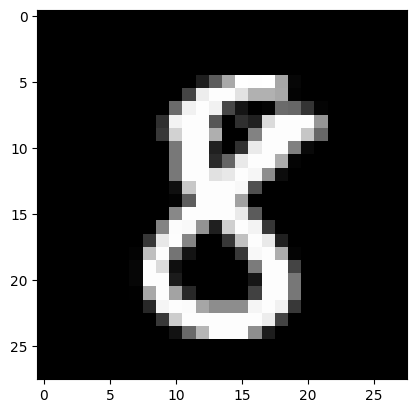

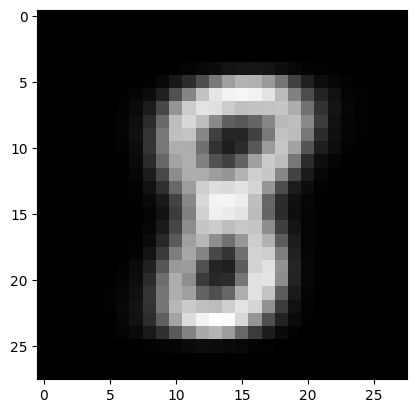

epoch 73, loss=1772.5242919921875, reconstruction_loss=2443.733154296875, KLD=1101.3155517578125


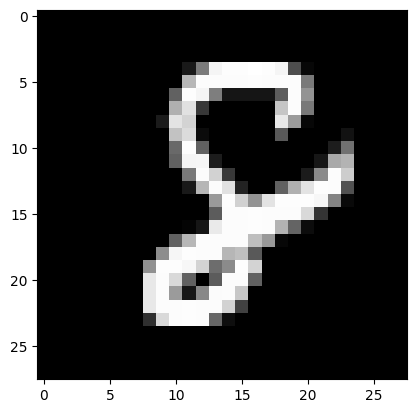

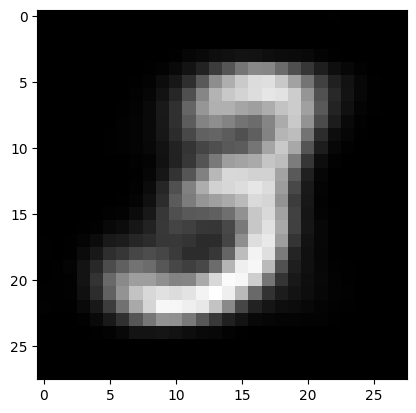

epoch 74, loss=1770.781494140625, reconstruction_loss=2441.23095703125, KLD=1100.3321533203125


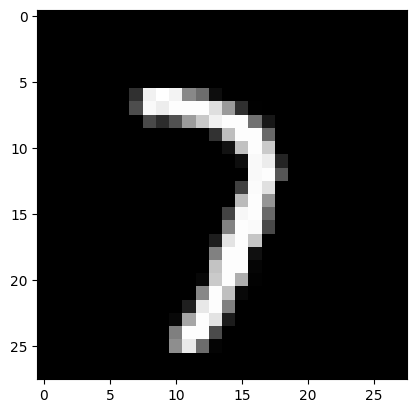

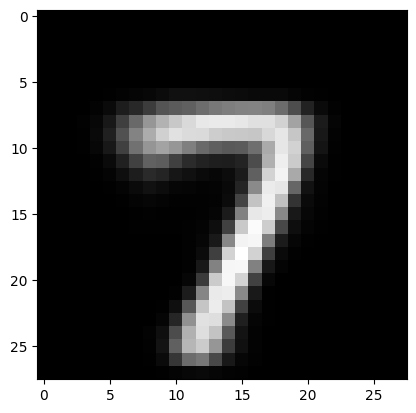

epoch 75, loss=1771.9466552734375, reconstruction_loss=2440.20458984375, KLD=1103.6881103515625


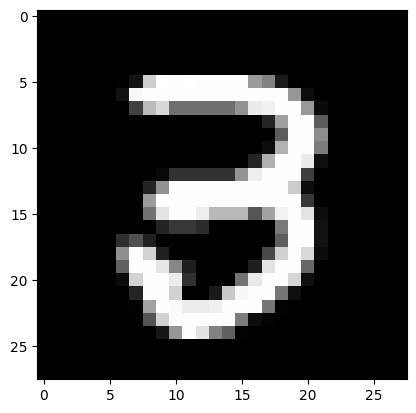

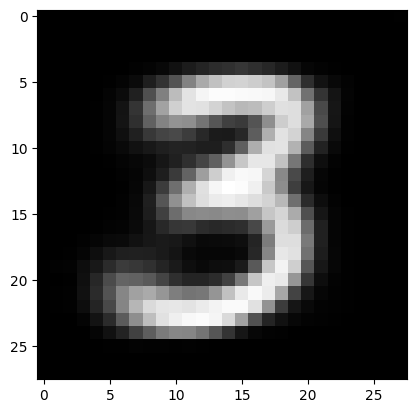

epoch 76, loss=1772.8804931640625, reconstruction_loss=2439.990234375, KLD=1105.7708740234375


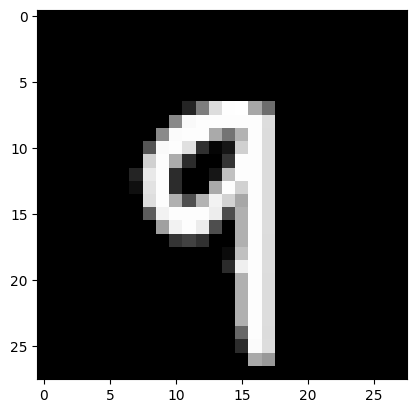

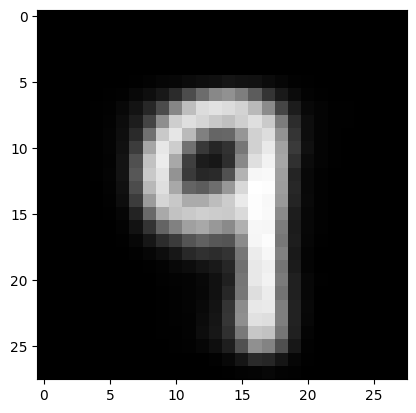

epoch 77, loss=1770.32275390625, reconstruction_loss=2436.16455078125, KLD=1104.479736328125


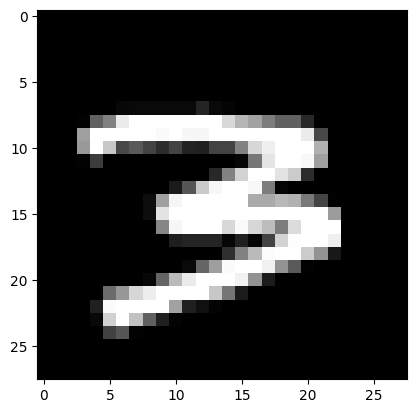

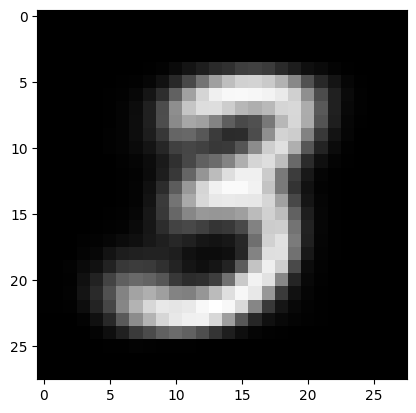

epoch 78, loss=1772.1611328125, reconstruction_loss=2436.737060546875, KLD=1107.5845947265625


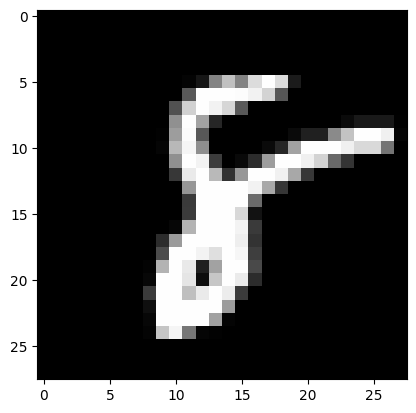

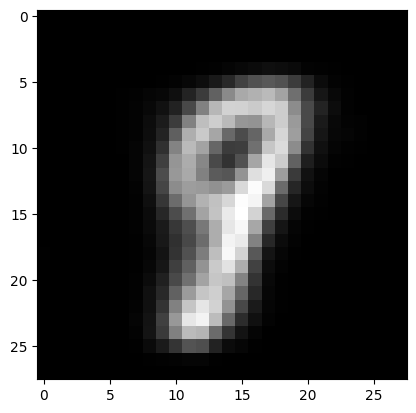

epoch 79, loss=1773.3914794921875, reconstruction_loss=2438.828125, KLD=1107.9547119140625


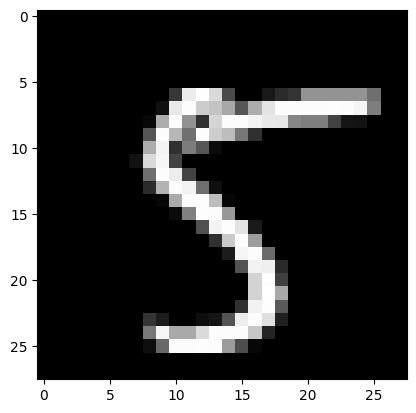

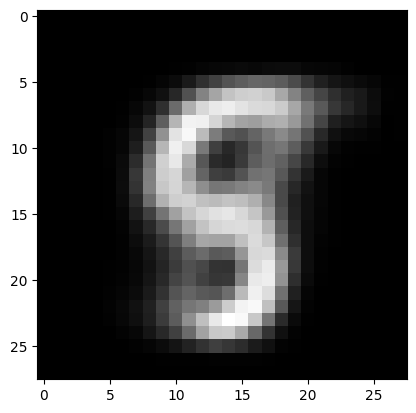

epoch 80, loss=1772.2015380859375, reconstruction_loss=2434.4814453125, KLD=1109.9212646484375


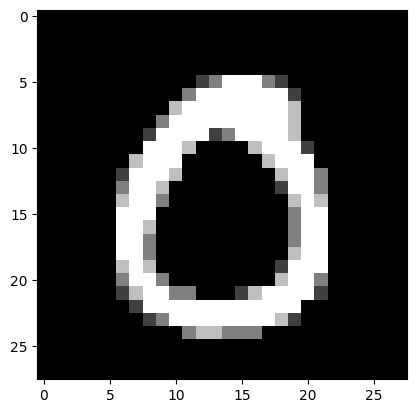

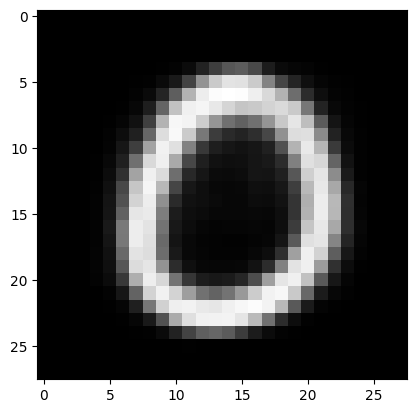

epoch 81, loss=1772.1263427734375, reconstruction_loss=2434.336181640625, KLD=1109.9171142578125


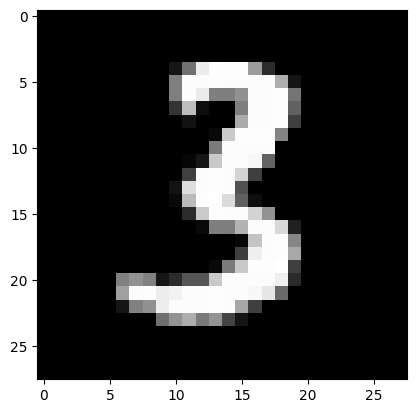

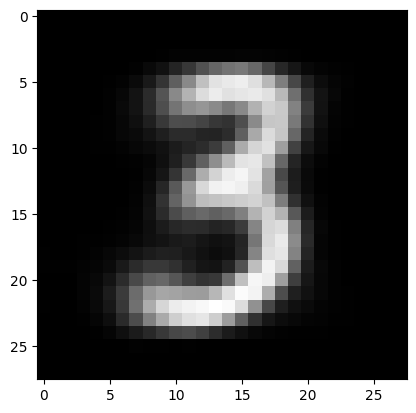

epoch 82, loss=1771.69140625, reconstruction_loss=2431.0390625, KLD=1112.3428955078125


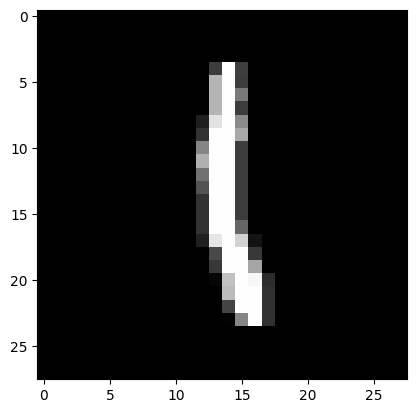

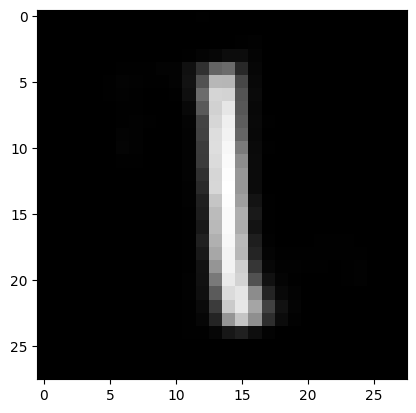

epoch 83, loss=1771.6439208984375, reconstruction_loss=2431.525146484375, KLD=1111.762939453125


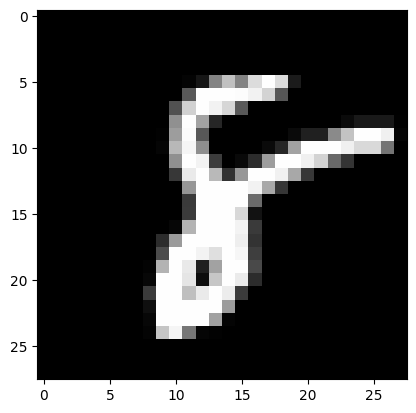

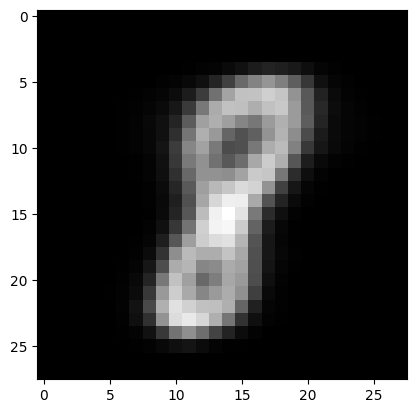

epoch 84, loss=1771.769287109375, reconstruction_loss=2430.78076171875, KLD=1112.757568359375


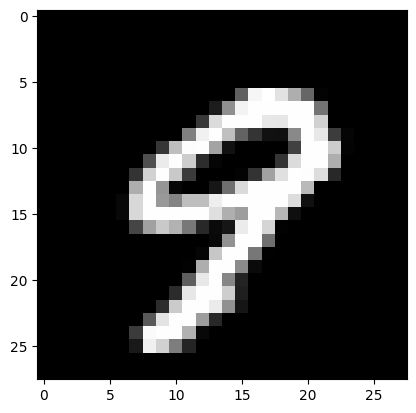

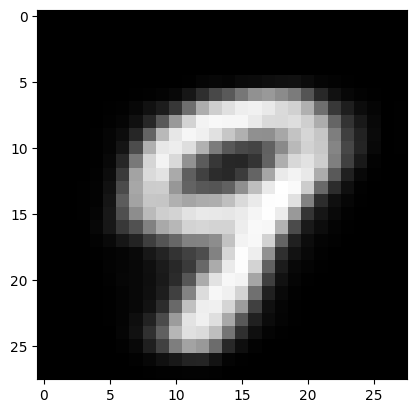

epoch 85, loss=1770.7166748046875, reconstruction_loss=2432.281982421875, KLD=1109.1519775390625


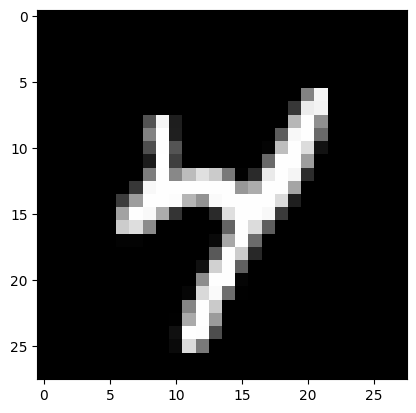

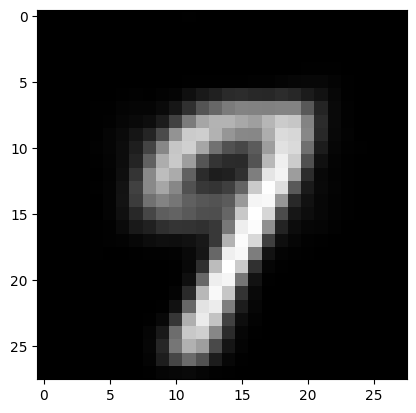

epoch 86, loss=1769.6651611328125, reconstruction_loss=2431.188232421875, KLD=1108.1419677734375


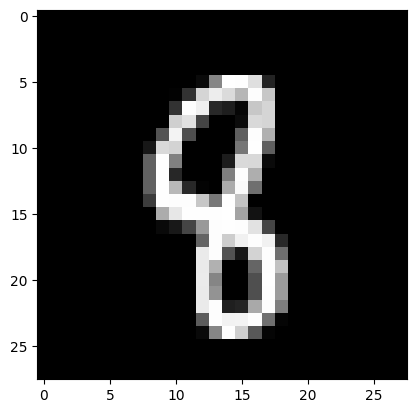

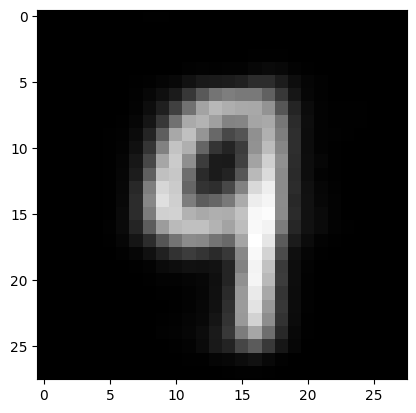

epoch 87, loss=1770.1925048828125, reconstruction_loss=2427.00927734375, KLD=1113.375


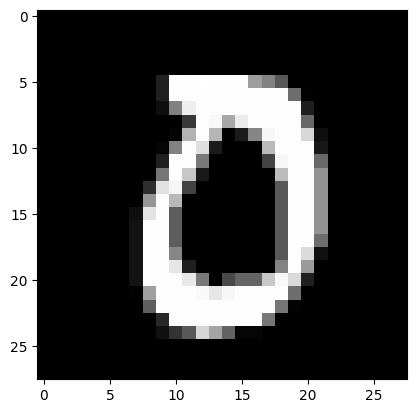

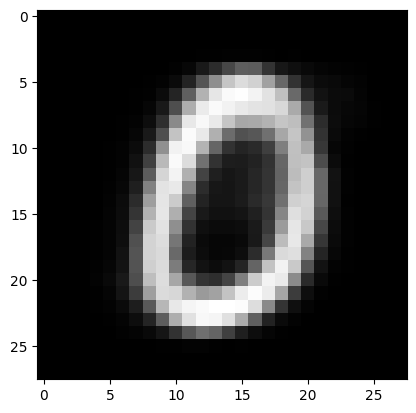

epoch 88, loss=1769.8480224609375, reconstruction_loss=2428.239990234375, KLD=1111.454833984375


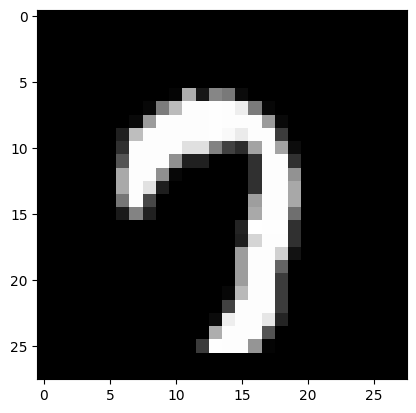

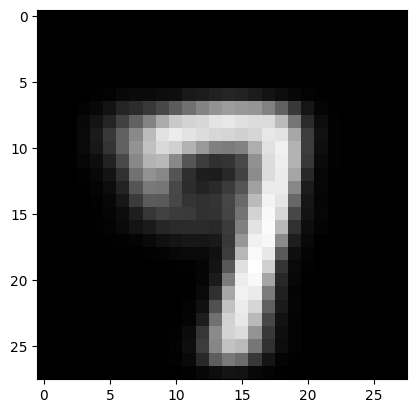

epoch 89, loss=1770.558349609375, reconstruction_loss=2424.491943359375, KLD=1116.6239013671875


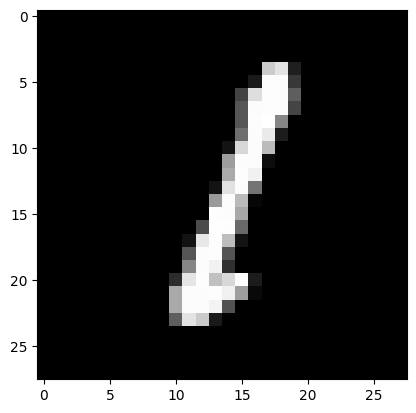

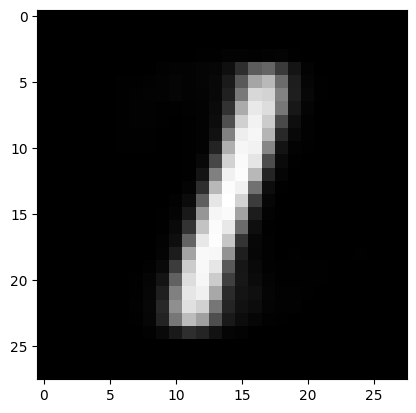

epoch 90, loss=1769.43994140625, reconstruction_loss=2423.589111328125, KLD=1115.2919921875


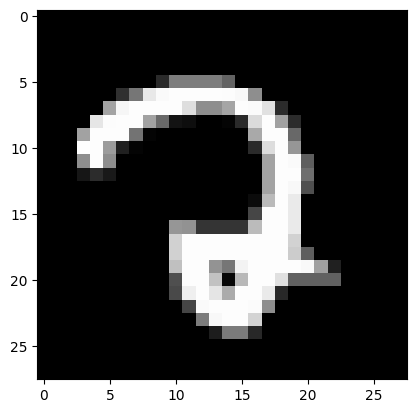

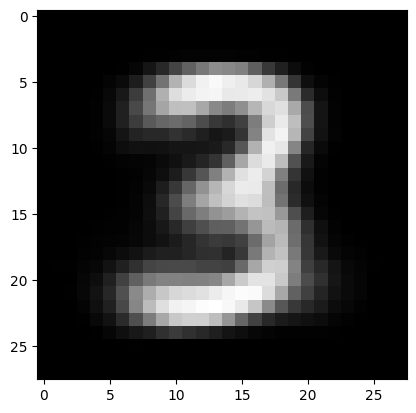

epoch 91, loss=1767.5382080078125, reconstruction_loss=2420.9189453125, KLD=1114.157470703125


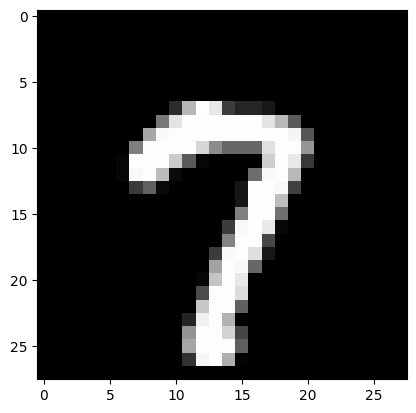

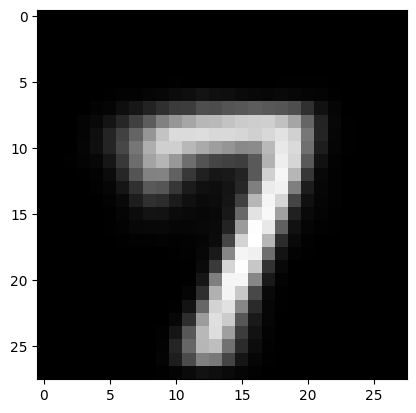

epoch 92, loss=1768.2332763671875, reconstruction_loss=2422.668701171875, KLD=1113.79931640625


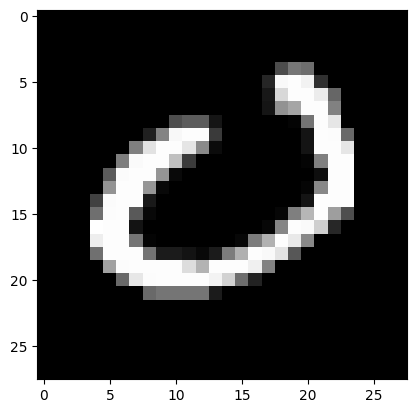

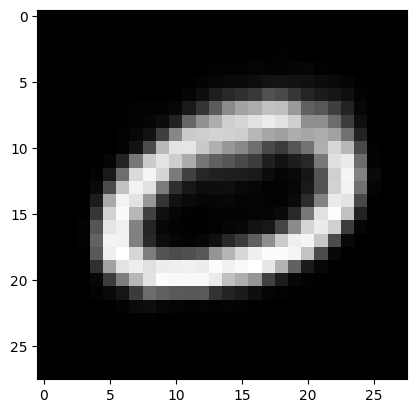

epoch 93, loss=1768.6932373046875, reconstruction_loss=2422.80029296875, KLD=1114.5882568359375


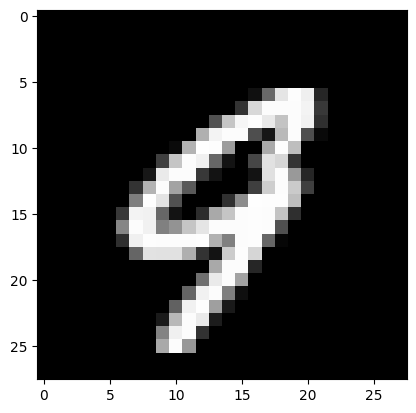

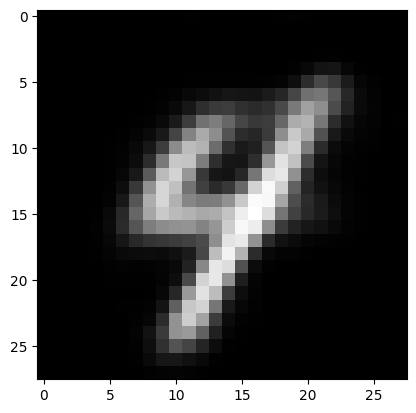

epoch 94, loss=1768.414794921875, reconstruction_loss=2422.024658203125, KLD=1114.804443359375


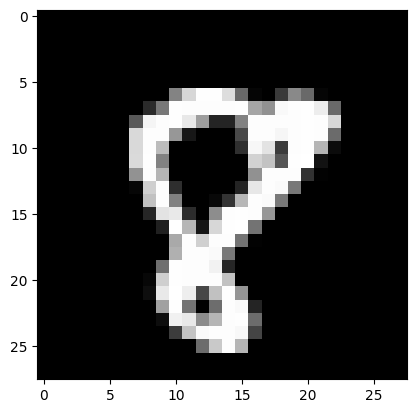

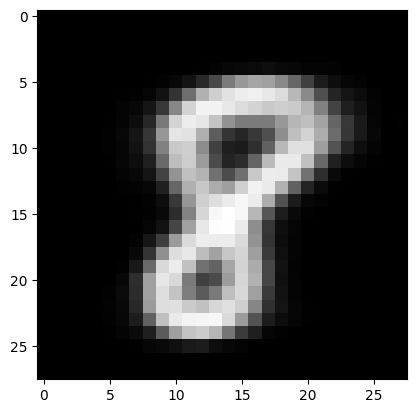

epoch 95, loss=1768.9193115234375, reconstruction_loss=2417.27587890625, KLD=1120.562255859375


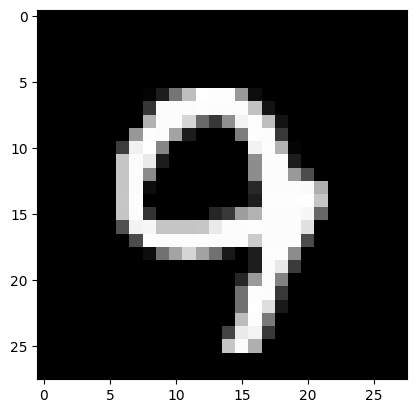

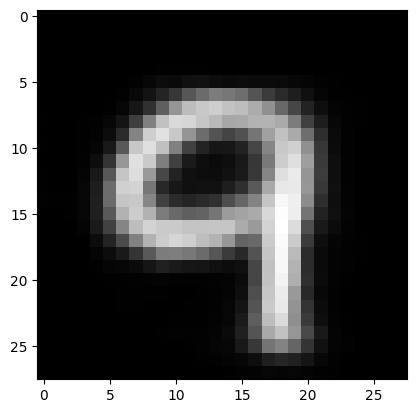

epoch 96, loss=1765.9375, reconstruction_loss=2413.804443359375, KLD=1118.069091796875


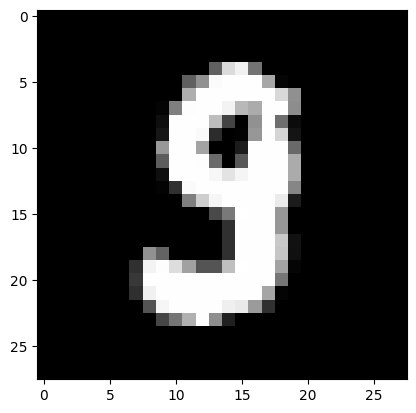

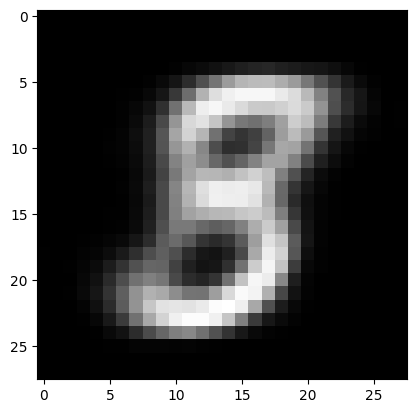

epoch 97, loss=1769.331298828125, reconstruction_loss=2418.207275390625, KLD=1120.4556884765625


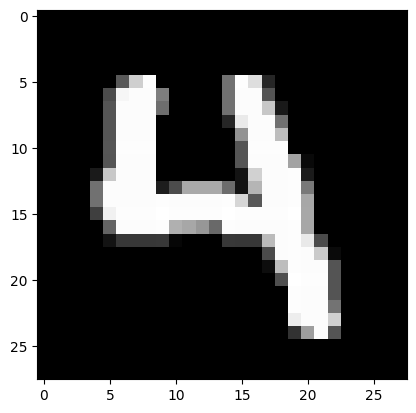

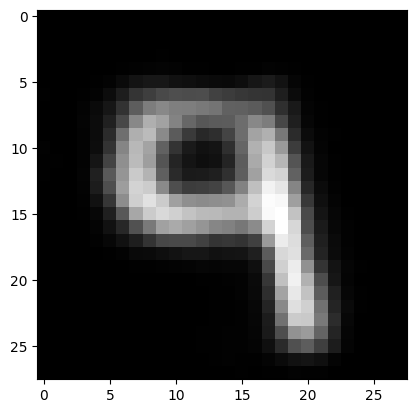

epoch 98, loss=1768.01611328125, reconstruction_loss=2416.858154296875, KLD=1119.1737060546875


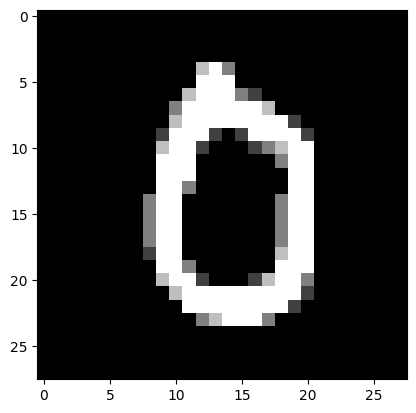

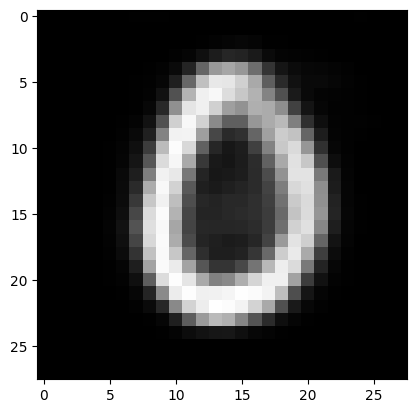

epoch 99, loss=1766.1754150390625, reconstruction_loss=2416.260009765625, KLD=1116.090576171875


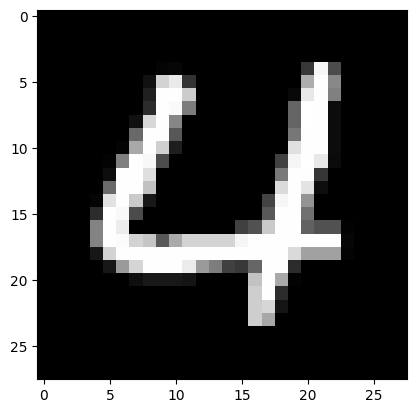

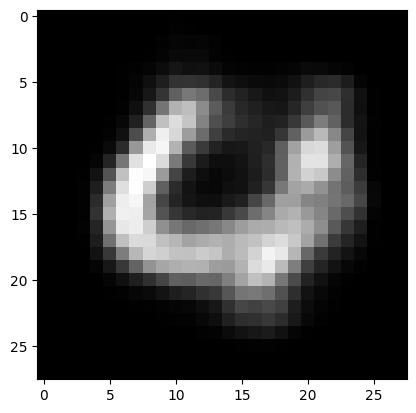

In [6]:
import tensorflow as tf
# from BetaVAE import BetaVAE
# from MnistDataSet import get_data_set

tf.keras.backend.clear_session()

model = BetaVAE(latent_size=4, beta=1)
train_dataset, test_dataset = get_data_set()
model.train(train_dataset, test_dataset)